In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score, roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize
from tqdm import tqdm
from scipy.fft import fft
import time

In [2]:
# Data explanation

# FONTOS: Minden event-re tamadaskent hivatkozunk (ettol fuggetlenul persze a nagy reszuk nem volt tamdas, csak magas forgalom)

# Tomoren: A components tabla elemei az egyes tamadasok soran keszult 'snapshot'-ok a halozat allapotarol (egy tamadashoz akar tobb ilyen 'snapshot' is lehet)
# Az events tabla elemei pedig egy-egy tamadast irnak le, igazabol az events tabla sorai az azonos Attack ID-val rendelkezo komponensek aggregacioja (atlaga, osszege, stb.)

##### Components #####
# Egy adott idopillanatban tukrozi halozat allapotat, egy snaphot
# Az Attack ID azonositja, hogy melyik tamadasnak a resze az adot idopillanatbeli allapot, ebben a tablaban az Attack ID nem egyedi
Components = {
    "Attack ID": "Egy adott tamadashoz (ami egy event) tartozo azonosito. Egy sora a tablanak azt mondja meg, hogy az adott tamadasnak az adott idopillanatban milyen allapotaban van a halozat.",
    "Detect count": "Azt mondja meg, hogy a bejegyzes az adott Attack ID-ju tamadasnak hanyadik detektalasa. pl lehet, hogy egy tamadast csak egyszer detektalunk, de lehet, hogy a tamadas soran tobbszor is valami gyanusat erzekelt a detektor es ezeket mindet feljegyezte",
    "Card": "A detektor melyik kartyaja vegezte az adatgyujtest",
    "Victim IP": "A tamadas aldozatanak IP cime (anonimizalva)",
    "Port number": "A tamadas cel portja",
    "Attack code": "A tamadas jelleget irja le, amibol gyanus volt a detektornak, hogy tamadas tortenik. pl.: High volume / Suspicious traffic, CLDAP. Akar tobb is lehet egy sorban.",
    "Significant flag": "A DDoS detektor belso flagje, SZAMUNKRA NEM FONTOS",
    "Packet speed": "csomagráta (hálózaton áthaladó csomagok száma másodpercenként) [pps]",
    "Data speed": "adatrata (hálózaton áthaladó adatmennyiség másodpercenként) [bps]",
    "Avg packet len": "átlagos csomaghossz [byte]",
    "Source IP count": "Egyedi IP cimek szama, akik az adott idopillanatban tamadnak",
    "Time": "Timestamp, hogy mikor keszult a snapshot"
}


##### Events #####
# egy-egy tamadast reprezental
# Azonos Attack ID-val rendelkezo komponensek aggregacioja, a teljes tamadast reprezentalja, az Attack ID egyedi
Events = {
    "Attack ID": "ugyanaz, mint a Components tablaban, de itt egyedi",
    "Card": "ugyanaz, mint a Components tablaban",
    "Victim IP": "ugyanaz, mint a Components tablaban",
    "Port number": "ugyanaz, mint a Components tablaban",
    "Attack code": "uyanaz, mint a Components tablaban, az adott Attack ID-hoz tartozo osszes komponens Attack code-janak az osszessege",
    "Detect count": "Hanyszor volt az adott Attack ID-val rendelkezo tamadas detektalva.",
    "Singificant flag": "ugyanugy nem fontos",
    "Packet speed": "Atlagos csomagráta a tamadas soran",
    "Data speed": "Atlagos adatrata a tamadas soran",
    "Avg packet len": "Atlagos csomaghossz a tamadas soran",
    "Avg Source IP count": "Atlagososan hany IP-rol tortent a tamadas",
    "Start time": "Timestamp, mikor kezdodott a tamadas",
    "End time": "Timestamp, mikor vegezodott a tamadas",
    "Whitelist flag": "Detektor belso flagje, SZAMUNKRA NEM FONTOS",
    "Type": "Az esemeny kategoriaja, aminek a detektor felcimkezte, ezt kell majd nekunk prediktalni neuralis haloval. Itt ez a 'ground truth' adat. Lehetseges ertekei: DDoS attack, Suspicious traffic vagy Normal traffic"
}

In [2]:
''' We should do the feature engineering here. For the model training this will be exported to a proper DataClass'''

component_columns = [
    "Attack ID", "Detect count", "Card", "Victim IP", "Port number",
    "Attack code", "Significant flag", "Packet speed", "Data speed", "Avg packet len",
    "Source IP count", "Time"
]

event_columns = [
    "Attack ID", "Card", "Victim IP", "Port number", "Attack code", 
    "Detect count", "Significant flag", "Packet speed", "Data speed", 
    "Avg packet len", "Avg source IP count", "Start time", "End time", 
    "Whitelist flag", "Type"
]

def get_fft(column, rel_times):
    # If only one value is present, return zeros to avoid errors
    if len(column) == 1:
        return 0,0

    values = column.values
    N = len(values)
    T = rel_times[-1] if rel_times[-1] > 0 else 1  # Time span in seconds

    fft_vals = fft(values)
    fft_mag = np.abs(fft_vals[:N // 2])  # Magnitudes
    fft_freq = np.fft.fftfreq(N, T / N)[:N // 2]  # Frequencies

    # Get the indices of the top magnitudes
    num_mags = min(len(fft_mag), 3)  # Handle cases with <3 magnitudes
    top_indices = np.argsort(fft_mag)[-num_mags:][::-1]  # Largest magnitudes in descending order

    # Select corresponding frequencies and phases
    top_magnitudes = fft_mag[top_indices].tolist()
    top_frequencies = fft_freq[top_indices].tolist()

    # Ensure the return values always have 3 elements
    while len(top_magnitudes) < 3:
        top_magnitudes.append(0)
        top_frequencies.append(0)

    return sum(top_magnitudes[1:]), sum(top_frequencies[1:])


def process_components(events, components):
    data = components.copy(deep=True)
    data.columns = component_columns
    
    e_data = events.copy(deep=True)
    e_data.columns = event_columns
    
    calculated_data = []
    # Group by 'Attack ID' and iterate over each group
        # Pre-convert 'Time' to datetime once
    data["Time"] = pd.to_datetime(data["Time"])
    
    # List to hold calculated values for each group
    calculated_data = []

    # Group by 'Attack ID' and iterate over each group
    grouped_data = data.groupby("Attack ID")
    for attack_id, group in tqdm(grouped_data):
        group = group.sort_values("Detect count")
        # Calculate relative time using numpy (much faster than pandas)
        times = group["Time"].values
        relative_time = np.cumsum(np.concatenate(([0], np.diff(times).astype(np.float64)))) / 10**9

        # Calculate the detection frequency (detections per second) [Hz]
        detection_frequency = 0 if relative_time[-1] == 0 else len(group) / relative_time[-1]

        # Standard deviation in network parameters
        packet_speed_std = group["Packet speed"].std(ddof=0)
        data_speed_std = group["Data speed"].std(ddof=0)
        avg_packet_len_std = group["Avg packet len"].std(ddof=0)
        source_ip_count_std = group["Source IP count"].std(ddof=0)
        
        packet_speed_burst_ratio = group["Packet speed"].max() / (group["Packet speed"].median() + 1)
        data_speed_burst_ratio = group["Data speed"].max() / (group["Data speed"].median() + 1)
        avg_packet_len_burst_ratio = group["Avg packet len"].max() / (group["Avg packet len"].median() + 1)
        source_ip_burst_ratio = group["Source IP count"].max() / (group["Source IP count"].median() + 1)
            
        # Measures how many packets are transmitted per unit of average packet length.
        packet_transmission_rate = np.where(group['Avg packet len'] == 0, 0, group['Packet speed'] / group['Avg packet len']).max()
        
        # Measures how many packets are transmitted per unit of data speed.
        packet_density = np.where(group['Data speed'] == 0, 0, group['Packet speed'] / group['Data speed']).max()   
        
        # Measures how much data (on average) is carried per unit of data speed. 
        packet_size_efficiency = np.where(group['Data speed'] == 0, 0, group['Avg packet len'] / group['Data speed']).max()        
        


        frequ_domain_values = []
        for col in ["Packet speed", "Data speed", "Avg packet len", "Source IP count"]:
            magnitudes, frequencies = get_fft(group[col], relative_time)
            frequ_domain_values.append([magnitudes, frequencies])


        # Collect calculated data for each attack
        calculated_data.append({
            "Attack ID": attack_id,
            "Detection Frequency": detection_frequency,
            "Packet Speed Std": packet_speed_std,
            "Data Speed Std": data_speed_std,
            "Avg Packet Len Std": avg_packet_len_std,
            "Source IP Count Std": source_ip_count_std,
            "Packet Speed Burst Ratio": packet_speed_burst_ratio,
            "Data Speed Burst Ratio": data_speed_burst_ratio,
            "Avg Packet Len Burst Ratio": avg_packet_len_burst_ratio,
            "Source IP Burst Ratio": source_ip_burst_ratio,
            "Packet Transmission Rate": packet_transmission_rate,
            "Packet Density": packet_density,
            "Packet Size Efficiency": packet_size_efficiency,
            "Packet Speed Ac Magnitude": frequ_domain_values[0][0],
            "Packet Speed Ac Frequency": frequ_domain_values[0][1],
            "Data Speed Ac Magnitude": frequ_domain_values[1][0],
            "Data Speed Ac Frequency": frequ_domain_values[1][1],
            "Avg Packet Len Ac Magnitude": frequ_domain_values[2][0],
            "Avg Packet Len Ac Frequency": frequ_domain_values[2][1],
            "Source IP Count Ac Magnitude": frequ_domain_values[3][0],
            "Source IP Count Ac Frequency": frequ_domain_values[3][1]
        })
        
    # Convert the calculated data into a DataFrame
    calculated_df = pd.DataFrame(calculated_data)

    # Merge the calculated data back into the events DataFrame
    e_data = pd.merge(e_data, calculated_df, on="Attack ID", how="left")
    print(e_data.columns)
    return e_data.reset_index(drop=True)


def add_time_features(p_events):
    events = p_events.copy(deep=True)
    events = events[events['End time'].astype(str) != '0']
    events['Start time'] = pd.to_datetime(events['Start time'])
    events['End time'] = pd.to_datetime(events['End time'])
    events['Duration'] = (events['End time'] - events['Start time']).dt.total_seconds().astype(int)
    events = events.drop(columns=['Victim IP', 'Significant flag', 'Whitelist flag', 'Start time', 'End time', "Card", "Attack code", "Attack ID"])
    cols = list(events.columns)
    cols[6], cols[-1] = cols[-1], cols[6]
    events = events[cols]
    
    # # 2. Hour of the day (optional: you can choose to store this directly or use booleans)
    # events['start_hour'] = events['Start time'].dt.hour
    # events['end_hour'] = events['End time'].dt.hour
    
    # 3. Boolean flags for each hour (this is optional, but if you'd like, here's an example)
    # for hour in range(24):
    #     events[f'is_hour_{hour}'] = events.apply(
    #         lambda row: hour >= row['start_hour'] and hour <= row['end_hour'], axis=1
    #     )
    return events

# Function to convert only numeric columns to float32
def convert_to_float32(col):
    # Check if the column is numeric
    if pd.api.types.is_numeric_dtype(col):
        return col.astype('float32')  # Convert to float32
    else:
        return col  # Return the column as is if not numeric

def train_random_forest_cls(events, num_train_sample = None):
    data = events.copy(deep=True)
    
    # Separate features and target
    X = data.iloc[:, :-1]  # All columns except the last one
    y = data.iloc[:, -1]   # Last column (target)

    # One-hot encode categorical columns
    categorical_cols = X.select_dtypes(include=['object']).columns
    X = pd.get_dummies(X, columns=categorical_cols)

    # Encode target variable to map ["Normal traffic", "Suspicios traffic", "DDoS attack"] to [0, 1, 2]
    if y.dtype == 'object':
        label_encoder = LabelEncoder()
        y = label_encoder.fit_transform(y)

    # Convert nuemrical values to to float32
    X = X.apply(convert_to_float32)

    # Split the datatset into training and testing sets
    if num_train_sample:
        X_train = X[:num_train_sample]
        y_train = y[:num_train_sample]
        X_test = X[num_train_sample:]
        y_test = y[num_train_sample:]
    else:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    clf = RandomForestClassifier(n_estimators=100, random_state=40)
    clf.fit(X_train, y_train)
    
    
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    importances = clf.feature_importances_
    feature_names = X.columns  # Get feature names

    # Create a DataFrame for better visualization
    feature_importance_df = pd.DataFrame({"Feature": feature_names, "Importance": importances})

    # Group the importances for features that start with "Attack code_"
    attack_code_columns = [col for col in feature_names if col.startswith("Attack code_")]

    # Filter out the Attack code features from the original feature importance DataFrame
    attack_code_importance = feature_importance_df[feature_importance_df["Feature"].isin(attack_code_columns)]["Importance"].sum()

    # Create a new entry for "Attack code" with the combined importance
    new_feature = pd.DataFrame({"Feature": ["Attack code"], "Importance": [attack_code_importance]})

    # Remove the original "Attack code_" features
    feature_importance_df = feature_importance_df[~feature_importance_df["Feature"].isin(attack_code_columns)]

    # Add the new "Attack code" row
    feature_importance_df = pd.concat([feature_importance_df, new_feature], ignore_index=True)

    # Sort by importance again
    feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)

    # Print the top features
    print(feature_importance_df)
    
    cm = confusion_matrix(y_test, y_pred)
    
    print(f"Overall accuracy: {accuracy:.2f}")

    
    # Calculate per-class accuracy
    class_accuracy = cm.diagonal() / cm.sum(axis=1)
    for i, class_name in enumerate(label_encoder.classes_):
        print(f"Accuracy for class '{class_name}': {class_accuracy[i]:.2f}")
        
    # Calculate F1 score (macro-average for the whole dataset)
    f1_macro = f1_score(y_test, y_pred, average='macro')
    f1_weighted = f1_score(y_test, y_pred, average='weighted')
    print(f"Macro-average F1 score: {f1_macro:.2f}") # This should be the important metric (F1 for each class and just averages those)
    print(f"Micro-average F1 score: {f1_weighted:.2f}")
    
    # Calculate F1 score for each class
    f1_scores = f1_score(y_test, y_pred, average=None)
    for class_name, f1 in zip(label_encoder.classes_, f1_scores):
        print(f"F1 score for class '{class_name}': {f1:.2f}")

    # For ROC-AUC, binarize the output (One-vs-Rest approach)
    y_test_bin = label_binarize(y_test, classes=[0, 1, 2])  # Adjust based on the number of classes
    y_pred_prob = clf.predict_proba(X_test)

    # Calculate ROC-AUC (macro-average for the whole dataset)
    roc_auc_macro = roc_auc_score(y_test_bin, y_pred_prob, average="macro", multi_class="ovr")
    roc_auc_micro = roc_auc_score(y_test_bin, y_pred_prob, average="micro", multi_class="ovr")
    print(f"Macro-average ROC-AUC: {roc_auc_macro:.2f}")
    print(f"Micro-average ROC-AUC: {roc_auc_micro:.2f}")

    # Plot ROC curve for each class
    fpr, tpr, _ = roc_curve(y_test_bin[:,0], y_pred_prob[:,0])
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc_macro:.2f}", c="green")
    # fpr, tpr, _ = roc_curve(y_test_bin[:, 0], y_pred_prob[:, 0])  # For 'Normal traffic'
    # plt.plot(fpr, tpr, label=f"Normal traffic (AUC = {roc_auc_macro:.2f})")
    # fpr, tpr, _ = roc_curve(y_test_bin[:, 1], y_pred_prob[:, 1])  # For 'Suspicious traffic'
    # plt.plot(fpr, tpr, label=f"Suspicious traffic (AUC = {roc_auc_macro:.2f})")
    # fpr, tpr, _ = roc_curve(y_test_bin[:, 2], y_pred_prob[:, 2])  # For 'DDoS attack'
    # plt.plot(fpr, tpr, label=f"DDoS attack (AUC = {roc_auc_macro:.2f})")

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

    plt.figure(figsize=(8, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
    disp.plot(cmap='Blues', values_format="d")
    plt.imshow(np.log1p(cm), cmap='Blues')  # Log transform for better visualization
    plt.show()
    



In [6]:
components_a = pd.read_csv("/home/appuser/data/train/SCLDDoS2024_SetA_components.csv")
events_a = pd.read_csv("/home/appuser/data/train/SCLDDoS2024_SetA_events.csv")

components_b = pd.read_csv("/home/appuser/data/train/SCLDDoS2024_SetB_components.csv")
events_b = pd.read_csv("/home/appuser/data/train/SCLDDoS2024_SetB_events.csv")

components_c = pd.read_csv("/home/appuser/data/test/SCLDDoS2024_SetC_components.csv")
events_c = pd.read_csv("/home/appuser/data/test/SCLDDoS2024_SetC_events.csv")

components_d = pd.read_csv("/home/appuser/data/gen/SCLDDoS2024_SetD_components.csv")
events_d = pd.read_csv("/home/appuser/data/gen/SCLDDoS2024_SetD_events.csv")

events_a = process_components(events_a, components_a)

events_b = process_components(events_b, components_b)

events_c = process_components(events_c, components_c)

events_d = process_components(events_d, components_d)

print("processing a")
events_extended_a = add_time_features(events_a)
events_extended_a.to_csv("/home/appuser/data/train/SCLDDoS2024_SetA_events_extended.csv", index=False)

print("processing b")
events_extended_b = add_time_features(events_b)
events_extended_b.to_csv("/home/appuser/data/train/SCLDDoS2024_SetB_events_extended.csv", index=False)

print("processing c")
events_extended_c = add_time_features(events_c)
events_extended_c.to_csv("/home/appuser/data/test/SCLDDoS2024_SetC_events_extended.csv", index=False)

print("processing d")
events_extended_d = add_time_features(events_d)
events_extended_d.to_csv("/home/appuser/data/gen/SCLDDoS2024_SetD_events_extended.csv", index=False)

100%|██████████| 134769/134769 [02:14<00:00, 1004.59it/s]


Index(['Attack ID', 'Card', 'Victim IP', 'Port number', 'Attack code',
       'Detect count', 'Significant flag', 'Packet speed', 'Data speed',
       'Avg packet len', 'Avg source IP count', 'Start time', 'End time',
       'Whitelist flag', 'Type', 'Detection Frequency', 'Packet Speed Std',
       'Data Speed Std', 'Avg Packet Len Std', 'Source IP Count Std',
       'Packet Speed Burst Ratio', 'Data Speed Burst Ratio',
       'Avg Packet Len Burst Ratio', 'Source IP Burst Ratio',
       'Packet Transmission Rate', 'Packet Density', 'Packet Size Efficiency',
       'Packet Speed Ac Magnitude', 'Packet Speed Ac Frequency',
       'Data Speed Ac Magnitude', 'Data Speed Ac Frequency',
       'Avg Packet Len Ac Magnitude', 'Avg Packet Len Ac Frequency',
       'Source IP Count Ac Magnitude', 'Source IP Count Ac Frequency'],
      dtype='object')


100%|██████████| 129999/129999 [02:10<00:00, 994.87it/s] 


Index(['Attack ID', 'Card', 'Victim IP', 'Port number', 'Attack code',
       'Detect count', 'Significant flag', 'Packet speed', 'Data speed',
       'Avg packet len', 'Avg source IP count', 'Start time', 'End time',
       'Whitelist flag', 'Type', 'Detection Frequency', 'Packet Speed Std',
       'Data Speed Std', 'Avg Packet Len Std', 'Source IP Count Std',
       'Packet Speed Burst Ratio', 'Data Speed Burst Ratio',
       'Avg Packet Len Burst Ratio', 'Source IP Burst Ratio',
       'Packet Transmission Rate', 'Packet Density', 'Packet Size Efficiency',
       'Packet Speed Ac Magnitude', 'Packet Speed Ac Frequency',
       'Data Speed Ac Magnitude', 'Data Speed Ac Frequency',
       'Avg Packet Len Ac Magnitude', 'Avg Packet Len Ac Frequency',
       'Source IP Count Ac Magnitude', 'Source IP Count Ac Frequency'],
      dtype='object')


100%|██████████| 130000/130000 [02:12<00:00, 981.84it/s] 


Index(['Attack ID', 'Card', 'Victim IP', 'Port number', 'Attack code',
       'Detect count', 'Significant flag', 'Packet speed', 'Data speed',
       'Avg packet len', 'Avg source IP count', 'Start time', 'End time',
       'Whitelist flag', 'Type', 'Detection Frequency', 'Packet Speed Std',
       'Data Speed Std', 'Avg Packet Len Std', 'Source IP Count Std',
       'Packet Speed Burst Ratio', 'Data Speed Burst Ratio',
       'Avg Packet Len Burst Ratio', 'Source IP Burst Ratio',
       'Packet Transmission Rate', 'Packet Density', 'Packet Size Efficiency',
       'Packet Speed Ac Magnitude', 'Packet Speed Ac Frequency',
       'Data Speed Ac Magnitude', 'Data Speed Ac Frequency',
       'Avg Packet Len Ac Magnitude', 'Avg Packet Len Ac Frequency',
       'Source IP Count Ac Magnitude', 'Source IP Count Ac Frequency'],
      dtype='object')


100%|██████████| 437657/437657 [07:19<00:00, 995.48it/s] 


Index(['Attack ID', 'Card', 'Victim IP', 'Port number', 'Attack code',
       'Detect count', 'Significant flag', 'Packet speed', 'Data speed',
       'Avg packet len', 'Avg source IP count', 'Start time', 'End time',
       'Whitelist flag', 'Type', 'Detection Frequency', 'Packet Speed Std',
       'Data Speed Std', 'Avg Packet Len Std', 'Source IP Count Std',
       'Packet Speed Burst Ratio', 'Data Speed Burst Ratio',
       'Avg Packet Len Burst Ratio', 'Source IP Burst Ratio',
       'Packet Transmission Rate', 'Packet Density', 'Packet Size Efficiency',
       'Packet Speed Ac Magnitude', 'Packet Speed Ac Frequency',
       'Data Speed Ac Magnitude', 'Data Speed Ac Frequency',
       'Avg Packet Len Ac Magnitude', 'Avg Packet Len Ac Frequency',
       'Source IP Count Ac Magnitude', 'Source IP Count Ac Frequency'],
      dtype='object')
processing a
processing b
processing c
processing d


                         Feature  Importance
5            Avg source IP count    0.131075
17                Packet Density    0.118948
13        Data Speed Burst Ratio    0.089177
3                     Data speed    0.081769
0                    Port number    0.080510
15         Source IP Burst Ratio    0.066003
18        Packet Size Efficiency    0.062304
4                 Avg packet len    0.057524
2                   Packet speed    0.056793
16      Packet Transmission Rate    0.044764
14    Avg Packet Len Burst Ratio    0.041317
6                       Duration    0.033251
12      Packet Speed Burst Ratio    0.028587
11           Source IP Count Std    0.019075
7            Detection Frequency    0.014059
10            Avg Packet Len Std    0.013735
8               Packet Speed Std    0.012325
9                 Data Speed Std    0.008984
1                   Detect count    0.007829
25  Source IP Count Ac Magnitude    0.007287
19     Packet Speed Ac Magnitude    0.004744
23   Avg P

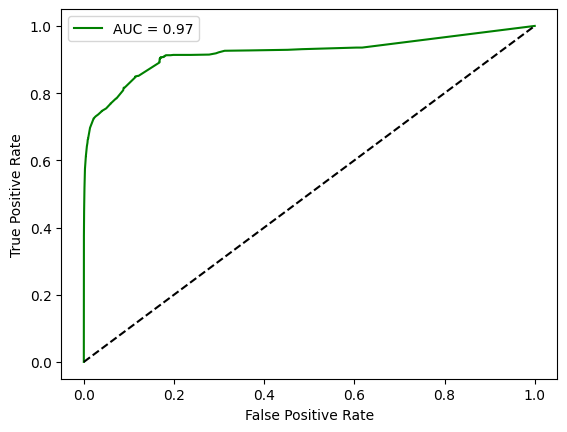

<Figure size 800x600 with 0 Axes>

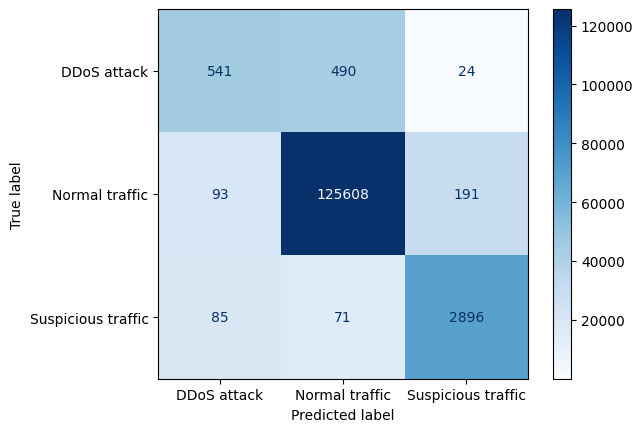

In [8]:
# RandomForestClassification

events_a = pd.read_csv("/home/appuser/data/train/SCLDDoS2024_SetA_events_extended.csv").fillna(0)
events_b = pd.read_csv("/home/appuser/data/train/SCLDDoS2024_SetB_events_extended.csv").fillna(0)
events_c = pd.read_csv("/home/appuser/data/test/SCLDDoS2024_SetC_events_extended.csv").fillna(0)
events_d = pd.read_csv("/home/appuser/data/gen/SCLDDoS2024_SetD_events_extended.csv").fillna(0)

num_train_sample = events_a.shape[0] + events_b.shape[0]
events_combined = pd.concat([events_a, events_b, events_c])
train_random_forest_cls(events_combined, num_train_sample)


In [40]:
component_columns = [
    "Attack ID", "Detect count", "Card", "Victim IP", "Port number",
    "Attack code", "Significant flag", "Packet speed", "Data speed", "Avg packet len",
    "Source IP count", "Time"
]

event_columns = [
    "Attack ID", "Card", "Victim IP", "Port number", "Attack code", 
    "Detect count", "Significant flag", "Packet speed", "Data speed", 
    "Avg packet len", "Avg source IP count", "Start time", "End time", 
    "Whitelist flag", "Type"
]

class DataPartition(Dataset):
    def __init__(self, data_partition):
        super().__init__()
        self.component_columns = component_columns
        self.event_columns = event_columns
        self.data_partition = data_partition
        self.components, self.events = self.load_data(data_partition)
        # VEDD KI A FLAGET IS (MERT TOK FELESLEGES)
        # HOZD AZ ADATOKAT HELYESS int/float pontossagra
        # one-hot encoding --> de nem trivialis
        self.filter_invalid_rows_from_events()
        self.add_duration_to_events()
        
    def load_data(self, data_partition):
        if data_partition == "A" or data_partition == "B":
            data_path = f'/home/appuser/data/train/SCLDDoS2024_Set{data_partition}'
        elif data_partition == "C":
            data_path = '/home/appuser/data/test/SCLDDoS2024_SetC'
        elif data_partition == "D":
            data_path = '/home/appuser/data/gen/SCLDDoS2024_SetD'
        else:
            raise ValueError("Invalid data partition, the valid options are: A, B, C, D")
        
        components = pd.read_csv(f'{data_path}_components.csv')
        events = pd.read_csv(f'{data_path}_events.csv')
        
        components.columns = self.component_columns
        events.columns = self.event_columns

        return components, events

    # remove the rows that has the End Time set to 0 as we don't know what that means
    def filter_invalid_rows_from_events(self):
        self.events = self.events[self.events['End time'].astype(str) != '0']

    # add a new column to the events dataframe that contains the duration of the event
    def add_duration_to_events(self):
        self.events['Start time'] = pd.to_datetime(self.events['Start time'])
        self.events['End time'] = pd.to_datetime(self.events['End time'])
        self.events['Duration'] = (self.events['End time'] - self.events['Start time']).dt.total_seconds().astype(int)
        
    def get_hist_bins_by_field(self, field):
        if field == "Duration":
            return np.arange(0, 305, 5), 10000
        elif field == 'Detect count':
            return np.arange(0, 51, 1), 50000
        elif field == "Avg source IP count":
            return np.arange(0, 360, 10), 50000
        elif field == "Avg packet len":
            return np.arange(1000, 1510, 10), 10000
        elif field == "Data speed":
            s = self.events[field]
            return np.arange(0, 1015, 15), 10000
            max_val = self.events[field].max()
            mean = self.events[field].mean()
            min_val = self.events[field].min()
            s = 0
        else:
            raise ValueError("You provided an invalid field option")

    # How much of the datatset is DDos attack, normal traffic and suspicious traffic
    def create_dist_pie_chart_for_events(self, save=False):
        event_types = self.events['Type'].value_counts()
        percentages = event_types / event_types.sum() * 100  # Calculate percentages
        labels = [f"{label} ({percent:.1f}%)" for label, percent in zip(event_types.index, percentages)]  # Add percentages to labels
        
        event_types.plot.pie(labels=labels, autopct='', startangle=0, fontsize=12)  # Remove autopct
        plt.ylabel('')
        plt.title(f'Event type distribution for data partition {self.data_partition}', fontsize=16)
        if save:
            plt.savefig(f'plots/event_distribution_{self.data_partition}.png',bbox_inches='tight')
        plt.show()
        
    # Create a histogram based on the 'field' column
    def create_histogram_for_events(self, field, save=False):
        data = self.events.copy(deep=True)
        plt.figure(figsize=(27, 9))
        bins, ymax = self.get_hist_bins_by_field(field)

        ax = sns.histplot(
            data=data, 
            x=field,
            hue='Type',  
            bins=bins, 
            multiple="stack",  
            alpha=0.8,
            hue_order=["DDoS attack", "Suspicious traffic", "Normal traffic"],
            palette={
                "DDoS attack": "#28a745",
                "Suspicious traffic": "#dc3545",
                "Normal traffic": "#007bff"
            },
            legend=True,
            edgecolor='none',
            element='bars',
            shrink=0.9,
        )

        plt.gca().set_facecolor('lavender')
        plt.title(f'Event {field} histogram for data partition {self.data_partition}', fontsize=20)
        plt.xlabel(f'{field}', fontsize=18)
        plt.ylabel('Number of Occurrences', fontsize=18)
        plt.ylim(0, ymax)
        xmax = max(bins)
        xmin = 1000 if field == "Avg packet len" else 0
        plt.xlim(xmin, xmax)

        # Format y-axis labels to show 'k' for thousands
        ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x/1000)}k'))

        # Increase font size for axis labels and ticks
        plt.tick_params(axis='both', labelsize=14)
        
        # Increase font size for legend
        plt.setp(ax.get_legend().get_texts(), fontsize=16)
        legend_title = ax.get_legend().get_title()
        if legend_title is not None:
            legend_title.set_fontsize(16)
        
        # Draw horizontal lines at the y-ticks (zorder = -1 puts it behind the columns)
        for y in ax.get_yticks():
            ax.axhline(y=y, color='white', linestyle='-', linewidth=2, alpha=0.5, zorder=-1) 
        
        if save:
            plt.savefig(f'plots/event_{field}_histogram_{self.data_partition}.png', bbox_inches='tight')
        plt.show()
        
    # Create a binwise normalised histogram based on the 'field' column
    def create_normalized_histogram_for_events(self, field, save=False):
        data = self.events.copy(deep=True)
        bins, _ = self.get_hist_bins_by_field(field)

        # Assign each data point to a bin
        data['bin'] = pd.cut(data[field], bins=bins, include_lowest=True)
    
        # Compute counts per bin per type
        counts = data.groupby(['bin', 'Type']).size().unstack(fill_value=0)

        # Normalize each bin so columns sum to 1
        normalized_counts = counts.div(counts.sum(axis=1), axis=0).fillna(0)        

        # Define categories
        categories = ["DDoS attack", "Suspicious traffic", "Normal traffic"]
        colors = ["#28a745", "#dc3545", "#007bff"]

        # Initialize the plot
        fig, ax = plt.subplots(figsize=(27, 9))
        
        ax.set_xticks(bins)  # Adjust step size as needed

        bottom = np.zeros(len(normalized_counts)) 
        for cat, color in zip(categories, colors):
            sns.barplot(
                x=bins[1:], 
                y=normalized_counts[cat], 
                color=color, 
                label=cat,
                edgecolor="none",
                bottom=bottom,
                alpha = 0.8,
            )
            bottom += normalized_counts[cat]  # Update bottom for stacking

        # Set background color
        ax.set_facecolor('lavender')

        # Set title, labels, and limits
        ax.set_title(f'Event {field} normalized histogram for data partition {self.data_partition}', fontsize=20)
        ax.set_xlabel(f'{field}', fontsize=18)
        ax.set_ylabel('Binwise relative proportion', fontsize=18)
        
        # Explicitly set x-limits and x-ticks
        plt.ylim(0, 1.1)
        
        ax.tick_params(axis='both', labelsize=14)
        
        # Increase font size for legend
        plt.setp(ax.get_legend().get_texts(), fontsize=16)
        legend_title = ax.get_legend().get_title()
        if legend_title is not None:
            legend_title.set_fontsize(16)

        # Draw horizontal lines at the y-ticks (zorder = -1 puts it behind the bars)
        for y in ax.get_yticks():
            ax.axhline(y=y, color='white', linestyle='-', linewidth=2, alpha=0.5, zorder=-1)

        # Save the figure if needed
        if save:
            plt.savefig(f'plots/event_{field}_normalized_histogram_{self.data_partition}.png', bbox_inches='tight')

        plt.show()
        
    def create_normalized_histogram_for_attack_code(self,save=False):
        data = self.events.copy(deep=True)
        unique_attack_types = set(code.strip() for codes in data["Attack code"] for code in codes.split(","))
        unique_attack_types = sorted(unique_attack_types)  # Sorting for consistency
        
        label_per_ptype = np.zeros((len(unique_attack_types), 3))
        
        for index, row in data.iterrows():
            if row["Type"] == "DDoS attack":
                idx = 0
            elif row["Type"] == "Suspicious traffic":
                idx = 1
            else:
                idx = 2
            attack_codes = [code.strip() for code in row["Attack code"].split(",")]
            for attack_code in attack_codes:
                s = unique_attack_types.index(attack_code)
                label_per_ptype[unique_attack_types.index(attack_code), idx] += 1
        label_per_ptype_normalized = label_per_ptype / label_per_ptype.sum(axis=1, keepdims=True)
        
        df_normalized = pd.DataFrame(label_per_ptype_normalized, columns=["DDoS attack", "Suspicious traffic", "Normal traffic"], index=unique_attack_types)
        print(df_normalized)
        
        # Define categories
        colors = ["#28a745", "#dc3545", "#007bff"]

        # Initialize the plot
        fig, ax = plt.subplots(figsize=(27, 9))
        
        ##ax.set_xticks(bins)  # Adjust step size as needed

        bottom = np.zeros(len(df_normalized)) 
        for cat, color in zip(df_normalized.columns, colors):
            sns.barplot(
                x=df_normalized.index, 
                y=df_normalized[cat], 
                color=color, 
                label=cat,
                edgecolor="none",
                bottom=bottom,
                alpha = 0.8,
            )
            bottom += df_normalized[cat]  # Update bottom for stacking

        # Set background color
        ax.set_facecolor('lavender')

        # Set title, labels, and limits
        ax.set_title(f'Attack code normalized histogram for data partition {self.data_partition}', fontsize=20)
        ax.set_xlabel("Attack code", fontsize=18)
        ax.set_ylabel('Binwise relative proportion', fontsize=18)
        
        # Explicitly set x-limits and x-ticks
        plt.ylim(0, 1.1)
        
        ax.tick_params(axis='both', labelsize=14)
        
        # Rotate the x-axis labels for readability
        plt.xticks(rotation=45, ha="right", fontsize=12)
        
        # Increase font size for legend
        plt.setp(ax.get_legend().get_texts(), fontsize=16)
        legend_title = ax.get_legend().get_title()
        if legend_title is not None:
            legend_title.set_fontsize(16)

        # Draw horizontal lines at the y-ticks (zorder = -1 puts it behind the bars)
        for y in ax.get_yticks():
            ax.axhline(y=y, color='white', linestyle='-', linewidth=2, alpha=0.5, zorder=-1)

        # Save the figure if needed
        if save:
            plt.savefig(f'plots/event_attack_code_normalized_histogram_{self.data_partition}.png', bbox_inches='tight')

        plt.show()

/tmp/ipykernel_761/15176242.py:150: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = data.groupby(['bin', 'Type']).size().unstack(fill_value=0)


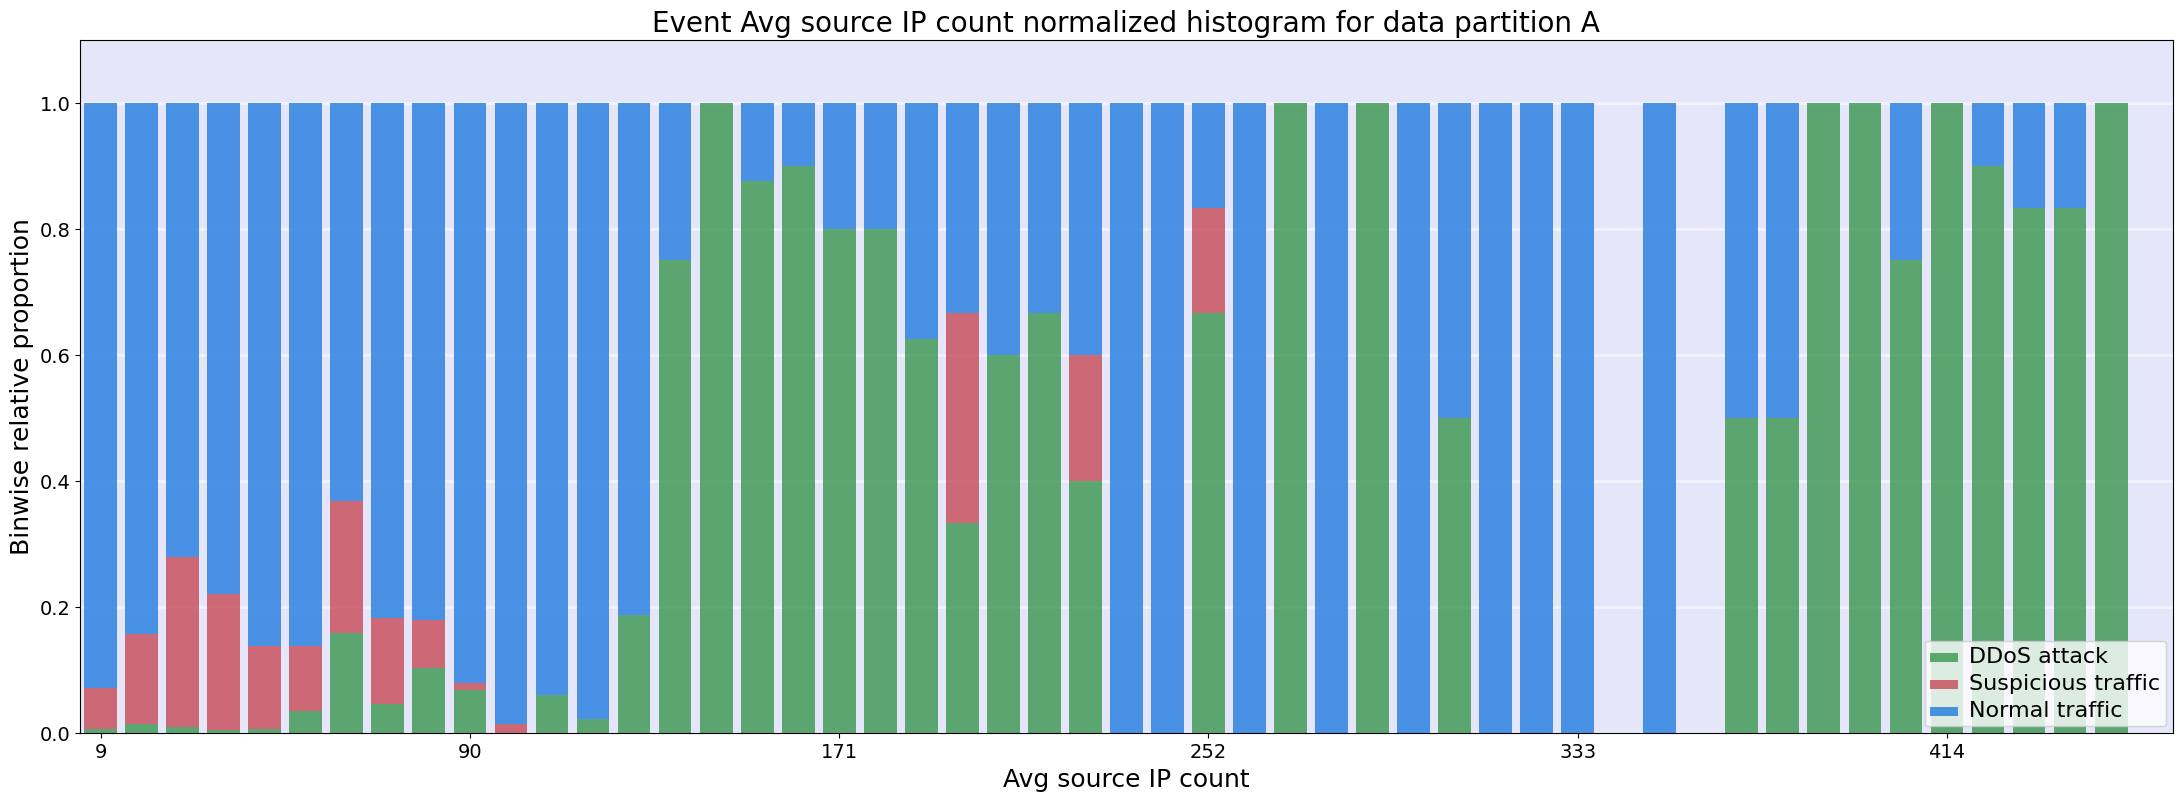

/tmp/ipykernel_761/15176242.py:150: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = data.groupby(['bin', 'Type']).size().unstack(fill_value=0)


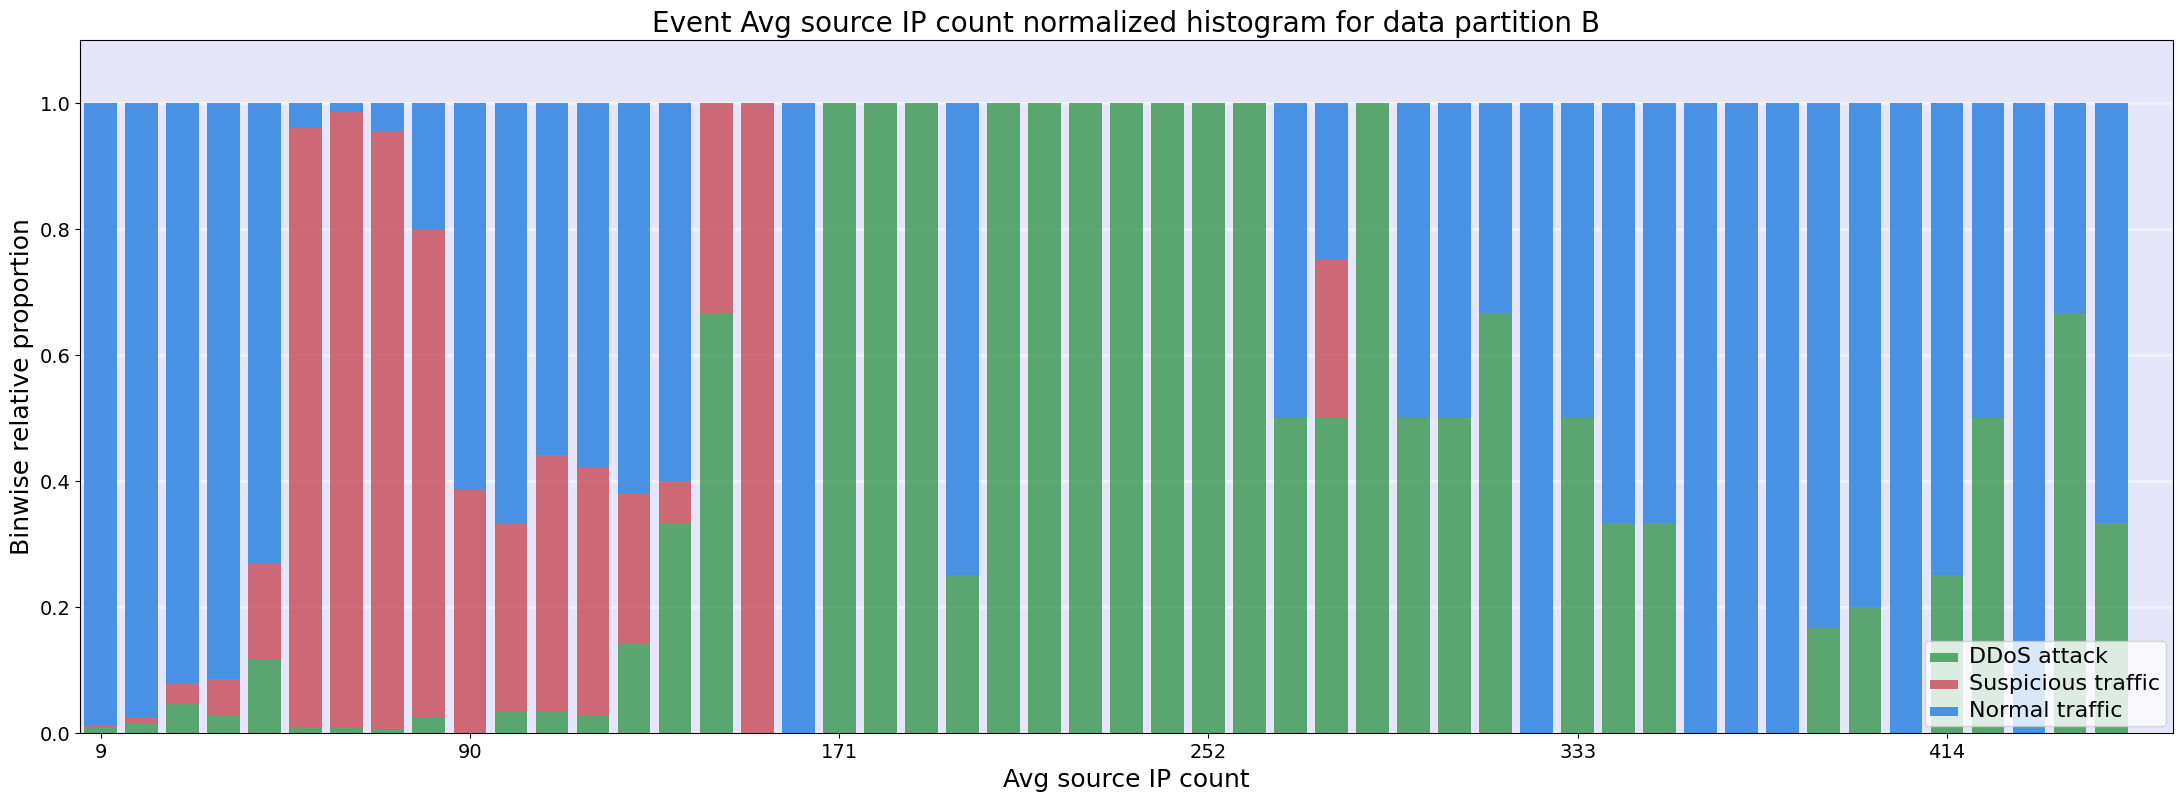

/tmp/ipykernel_761/15176242.py:150: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = data.groupby(['bin', 'Type']).size().unstack(fill_value=0)


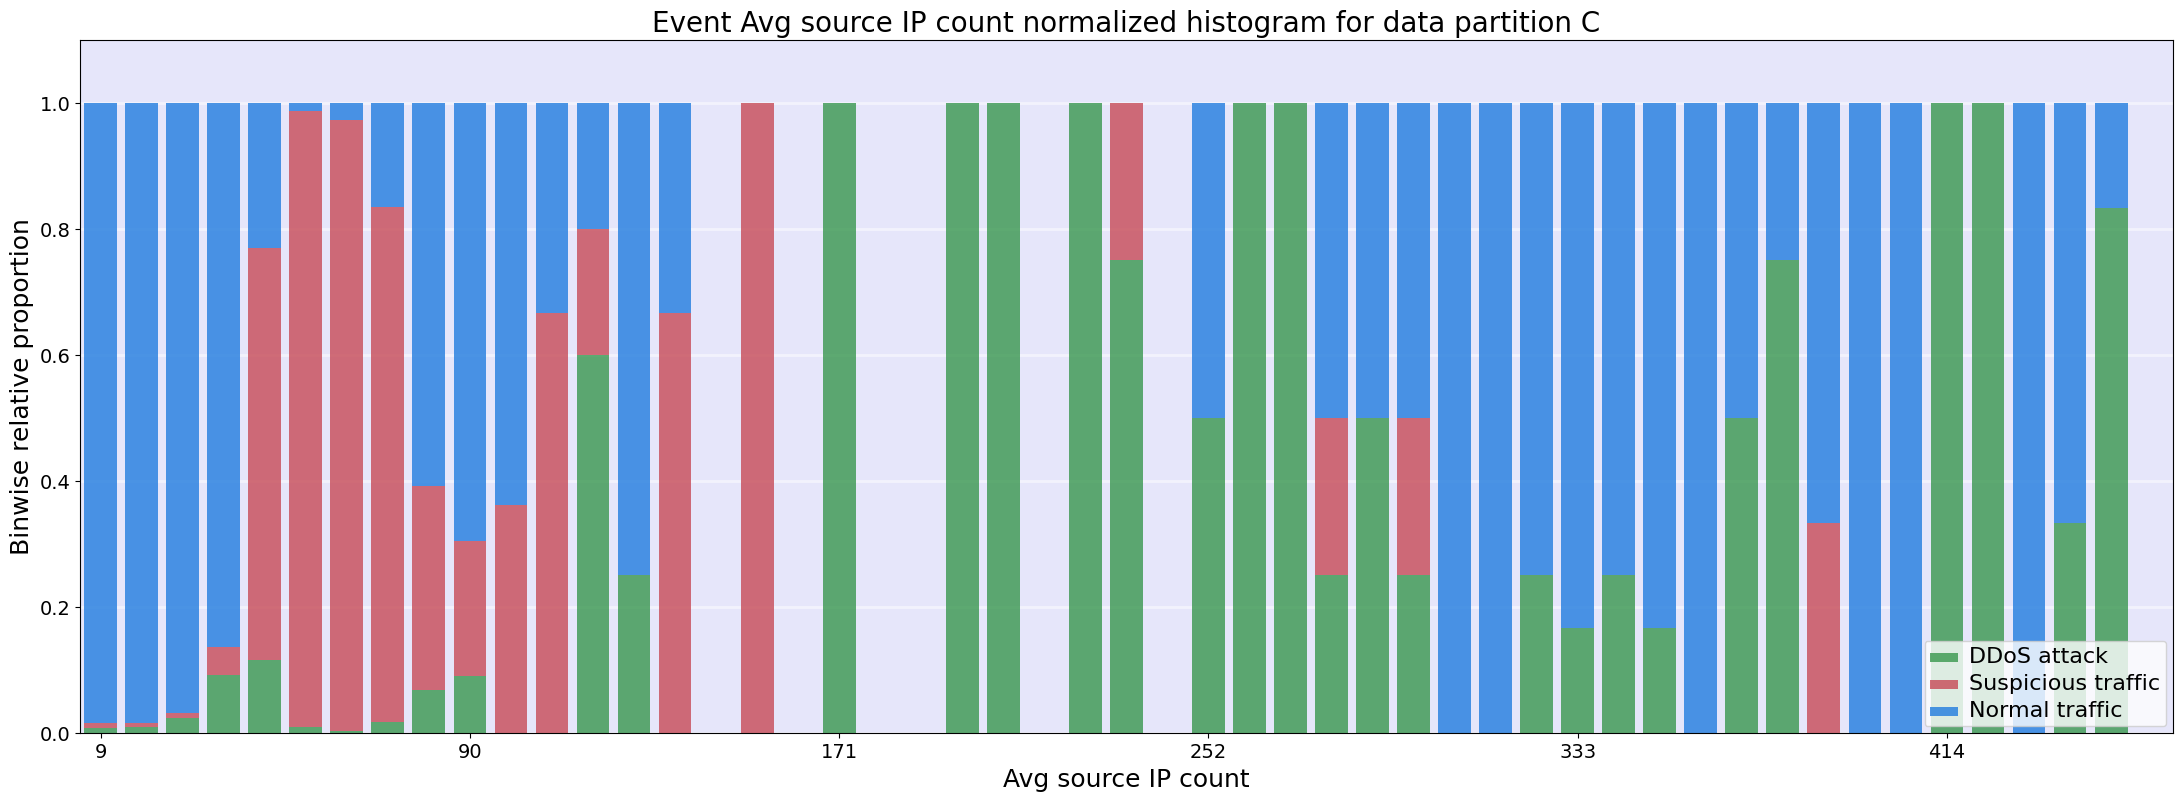

/tmp/ipykernel_761/15176242.py:150: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = data.groupby(['bin', 'Type']).size().unstack(fill_value=0)


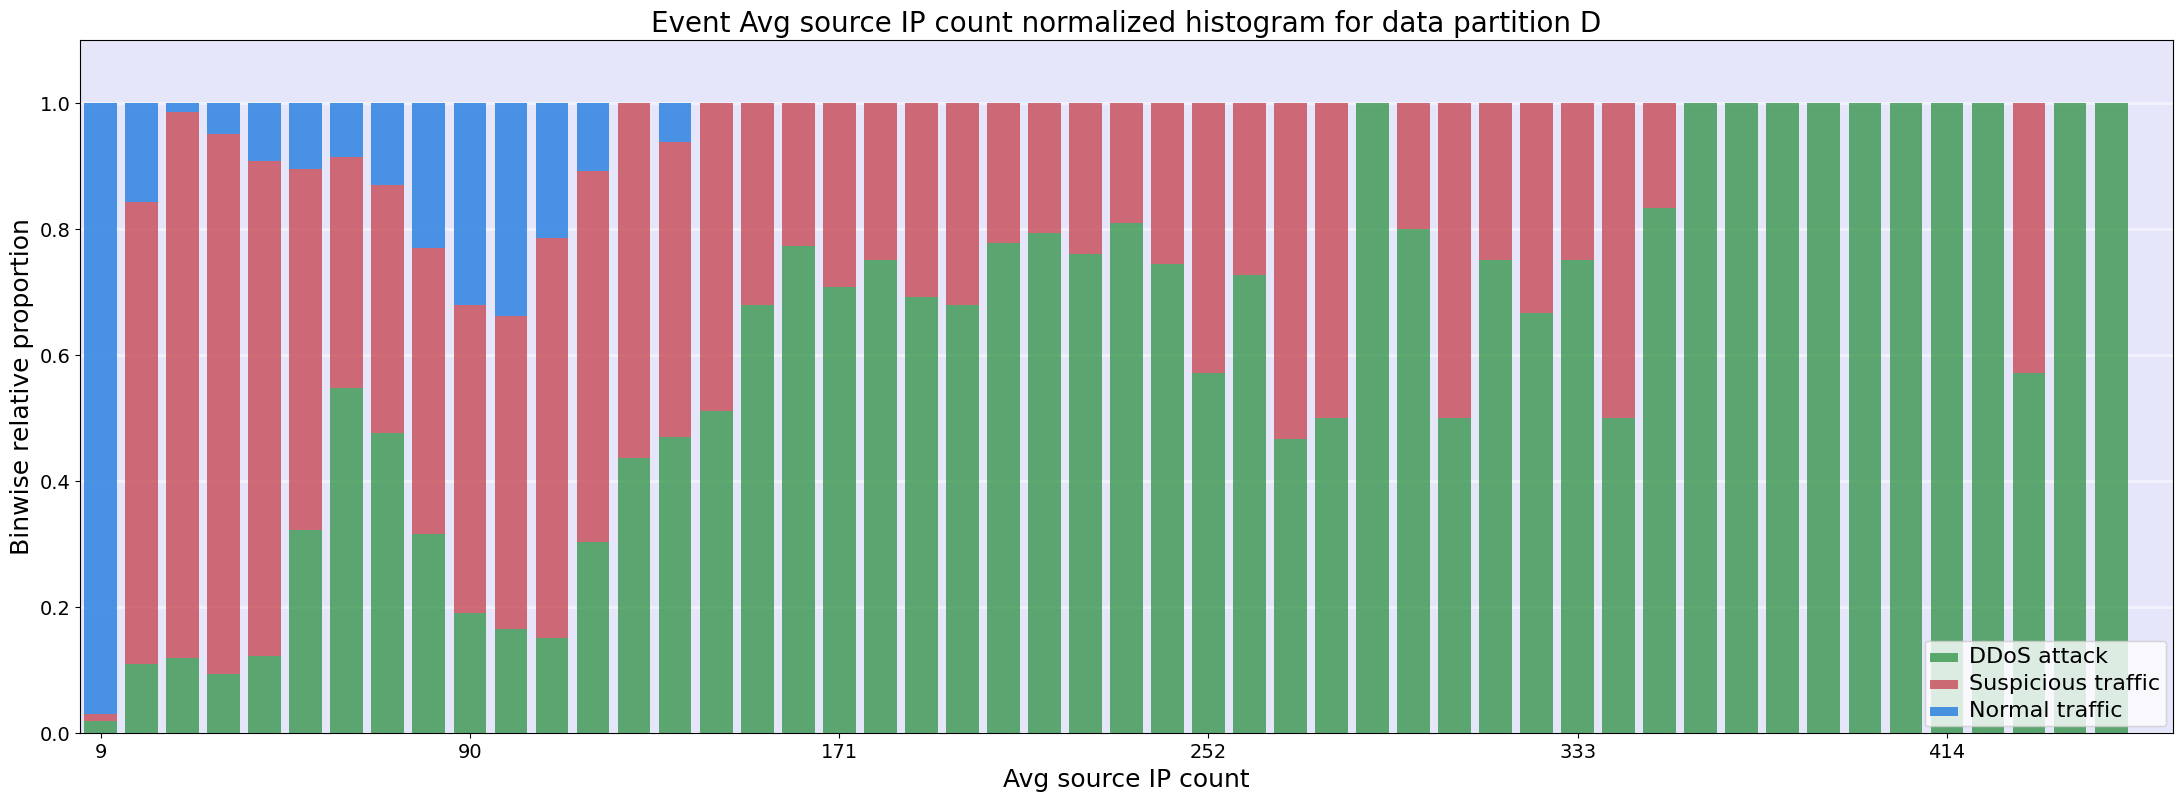

/tmp/ipykernel_761/15176242.py:150: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = data.groupby(['bin', 'Type']).size().unstack(fill_value=0)


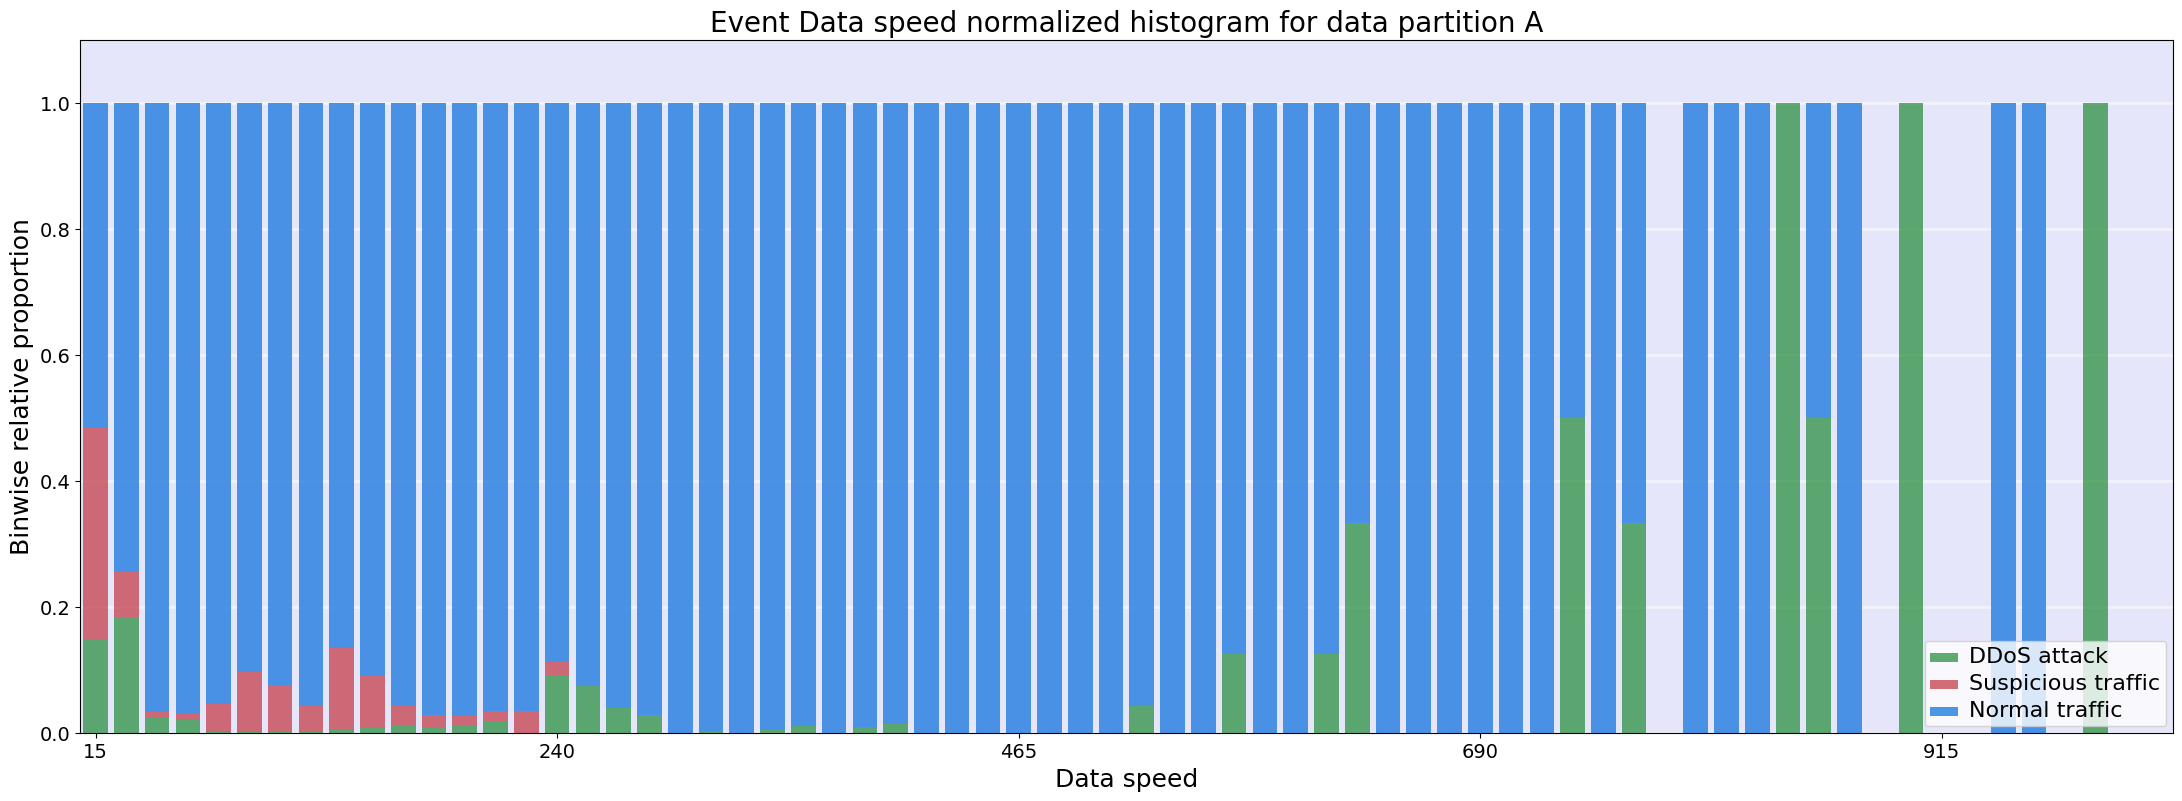

/tmp/ipykernel_761/15176242.py:150: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = data.groupby(['bin', 'Type']).size().unstack(fill_value=0)


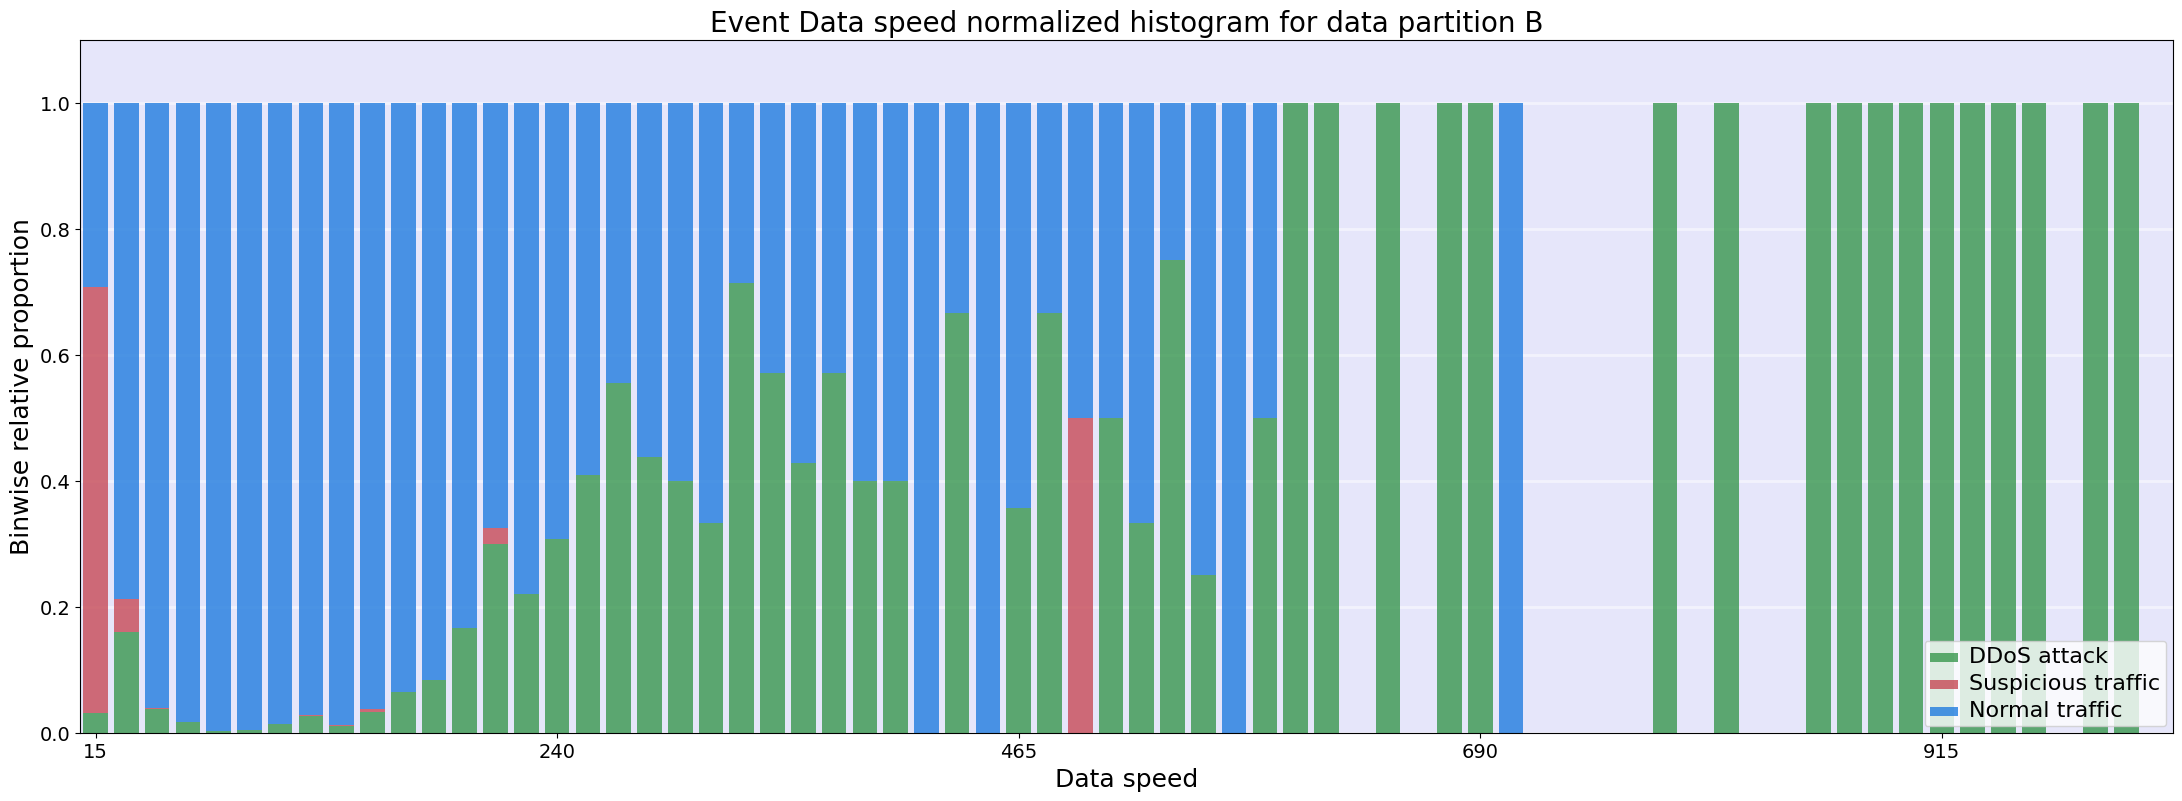

/tmp/ipykernel_761/15176242.py:150: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = data.groupby(['bin', 'Type']).size().unstack(fill_value=0)


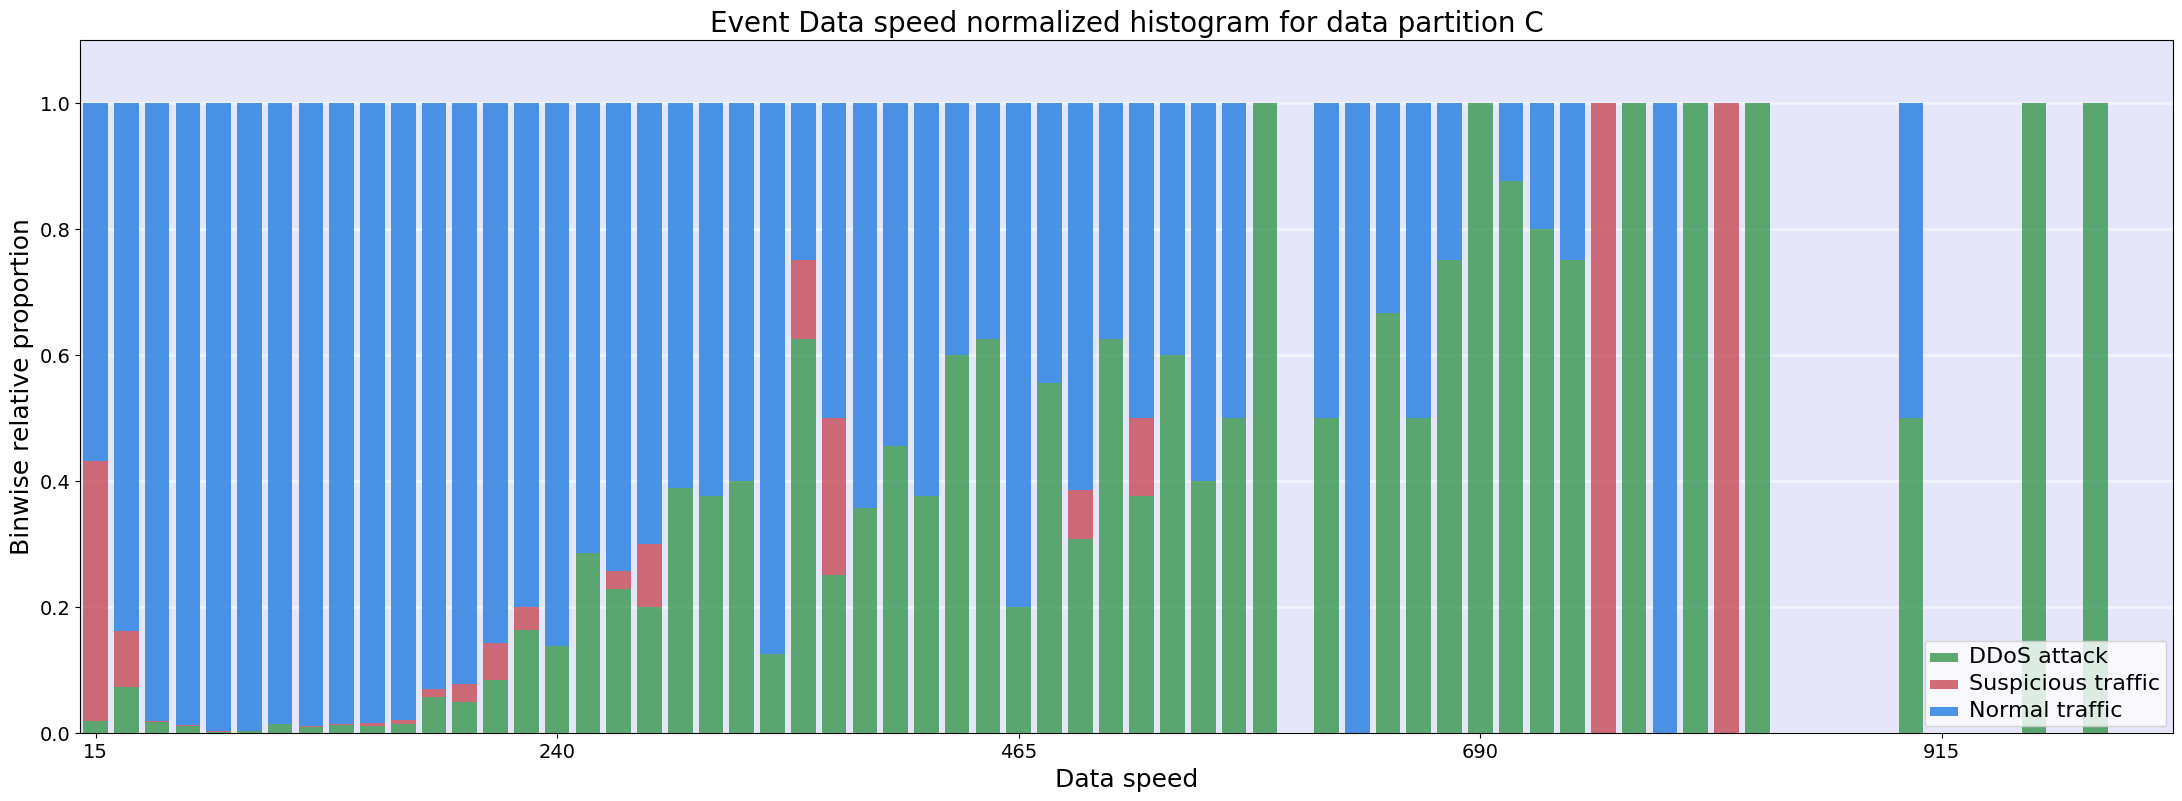

/tmp/ipykernel_761/15176242.py:150: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = data.groupby(['bin', 'Type']).size().unstack(fill_value=0)


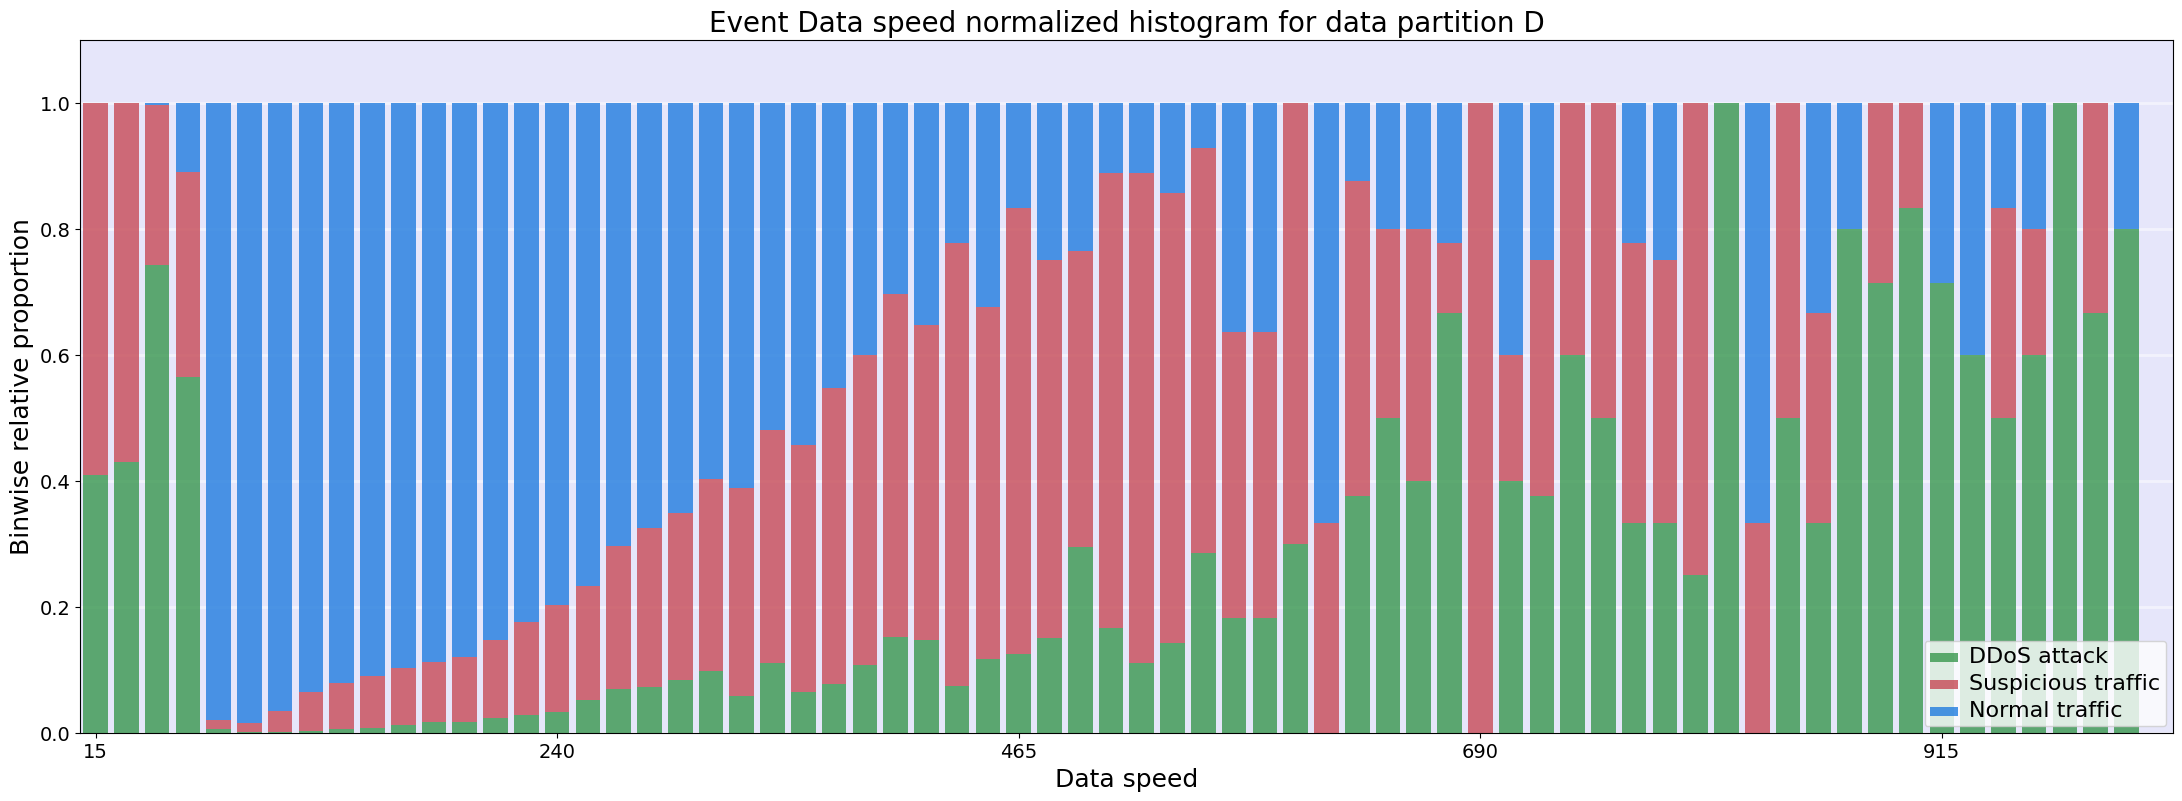

                     DDoS attack  Suspicious traffic  Normal traffic
ACK Attack              1.000000            0.000000        0.000000
CHARGEN                 1.000000            0.000000        0.000000
CLDAP                   1.000000            0.000000        0.000000
CoAP                    1.000000            0.000000        0.000000
DNS                     1.000000            0.000000        0.000000
Generic UDP             1.000000            0.000000        0.000000
High volume traffic     0.001663            0.024630        0.973707
IPv4 fragmentation      1.000000            0.000000        0.000000
NTP                     1.000000            0.000000        0.000000
RDP                     1.000000            0.000000        0.000000
RPC                     1.000000            0.000000        0.000000
SNMP                    1.000000            0.000000        0.000000
SSDP                    1.000000            0.000000        0.000000
SYN Attack              1.000000  

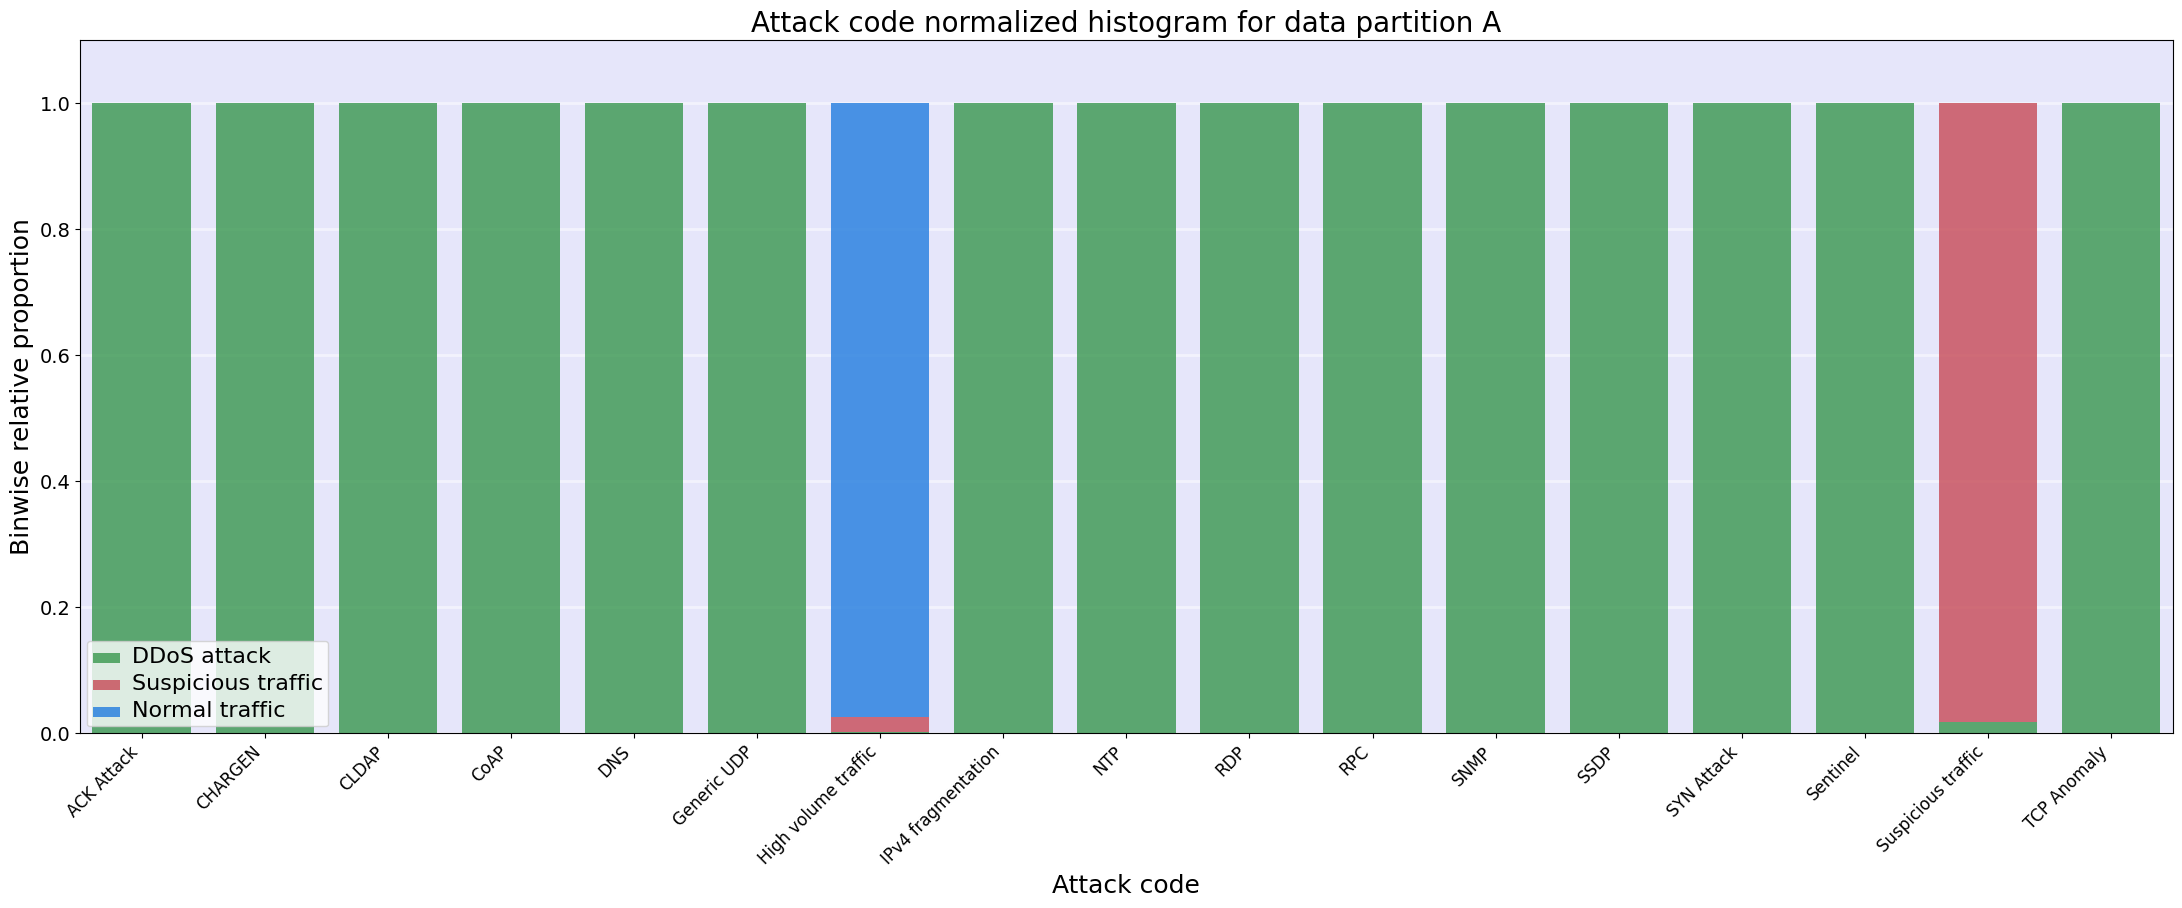

                     DDoS attack  Suspicious traffic  Normal traffic
CHARGEN                 1.000000            0.000000        0.000000
CLDAP                   1.000000            0.000000        0.000000
CoAP                    1.000000            0.000000        0.000000
DNS                     1.000000            0.000000        0.000000
Generic UDP             1.000000            0.000000        0.000000
High volume traffic     0.004477            0.000677        0.994846
ICMP                    0.000564            0.999436        0.000000
IPv4 fragmentation      1.000000            0.000000        0.000000
Memcached               1.000000            0.000000        0.000000
NTP                     1.000000            0.000000        0.000000
RDP                     1.000000            0.000000        0.000000
RPC                     1.000000            0.000000        0.000000
SSDP                    1.000000            0.000000        0.000000
SYN Attack              1.000000  

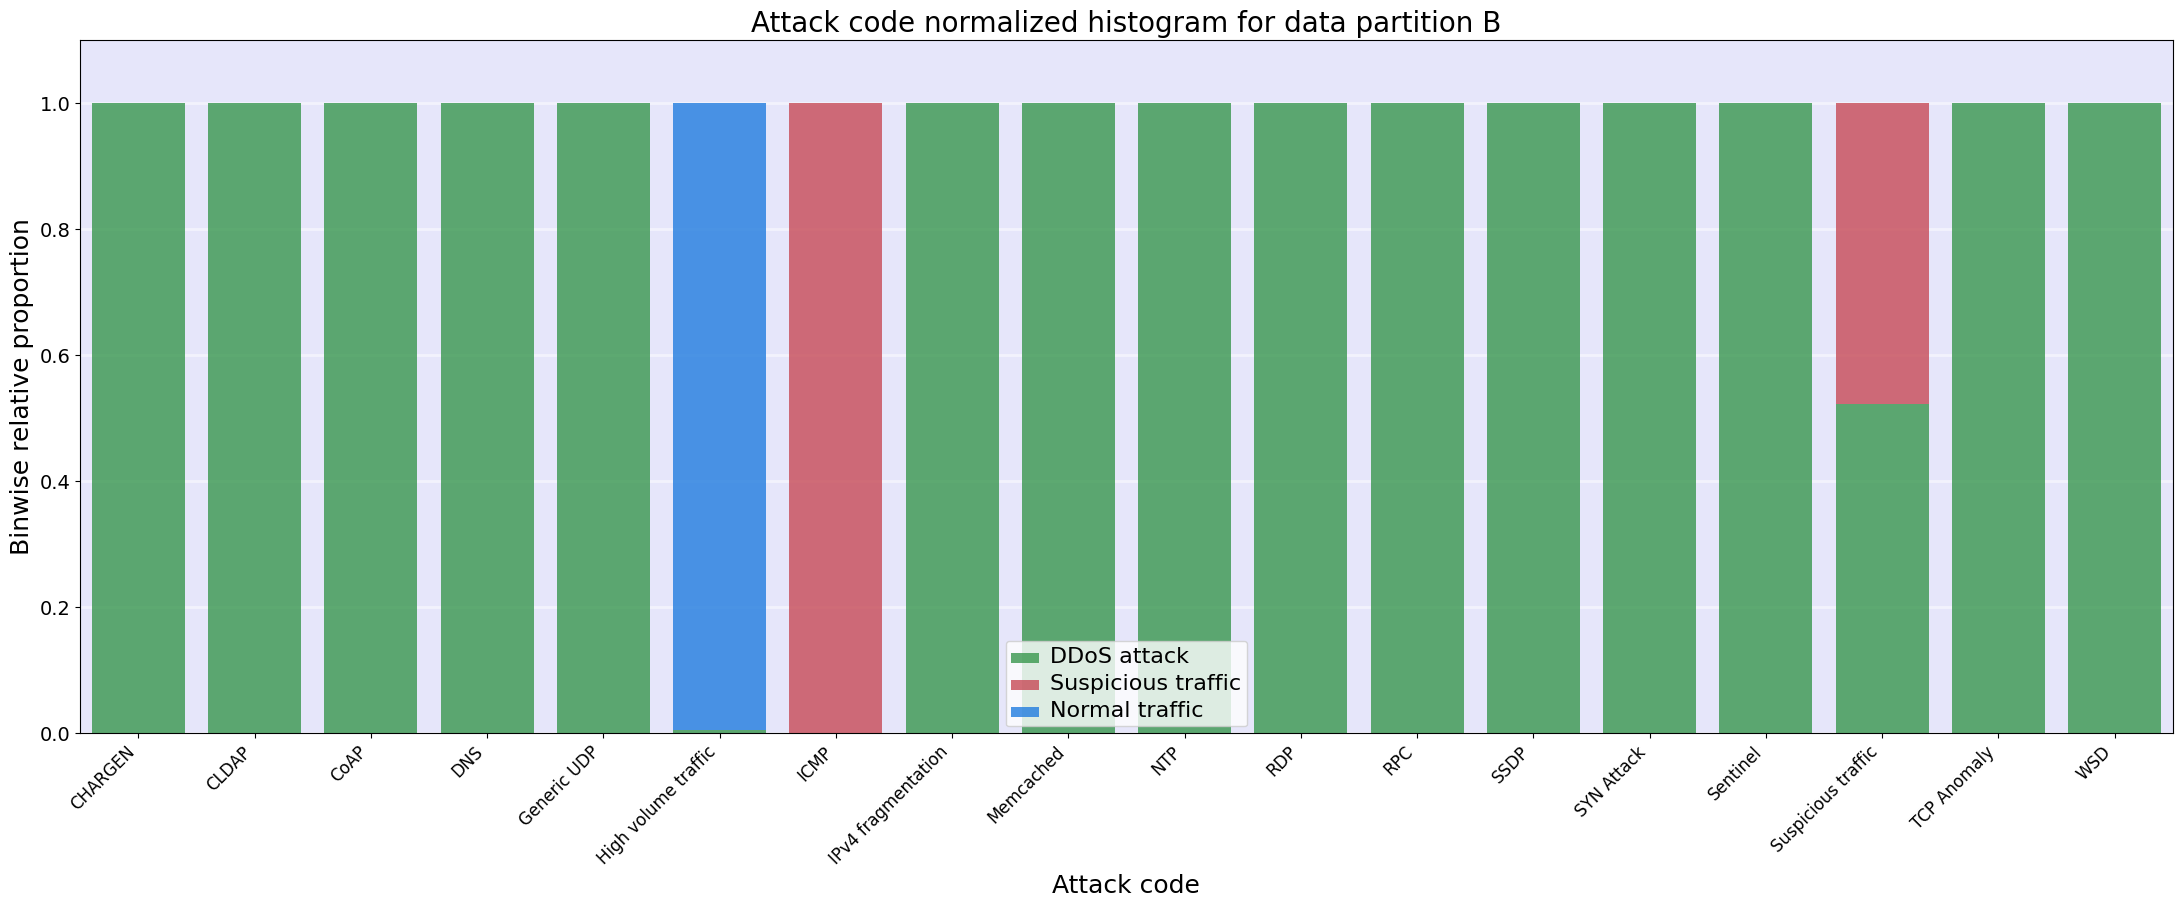

                     DDoS attack  Suspicious traffic  Normal traffic
CHARGEN                 1.000000            0.000000        0.000000
CLDAP                   1.000000            0.000000        0.000000
CoAP                    1.000000            0.000000        0.000000
DNS                     1.000000            0.000000        0.000000
Generic UDP             1.000000            0.000000        0.000000
High volume traffic     0.005193            0.002703        0.992104
ICMP                    0.001952            0.998048        0.000000
IPv4 fragmentation      1.000000            0.000000        0.000000
Memcached               1.000000            0.000000        0.000000
NTP                     1.000000            0.000000        0.000000
RDP                     1.000000            0.000000        0.000000
RIP                     1.000000            0.000000        0.000000
RPC                     1.000000            0.000000        0.000000
SNMP                    1.000000  

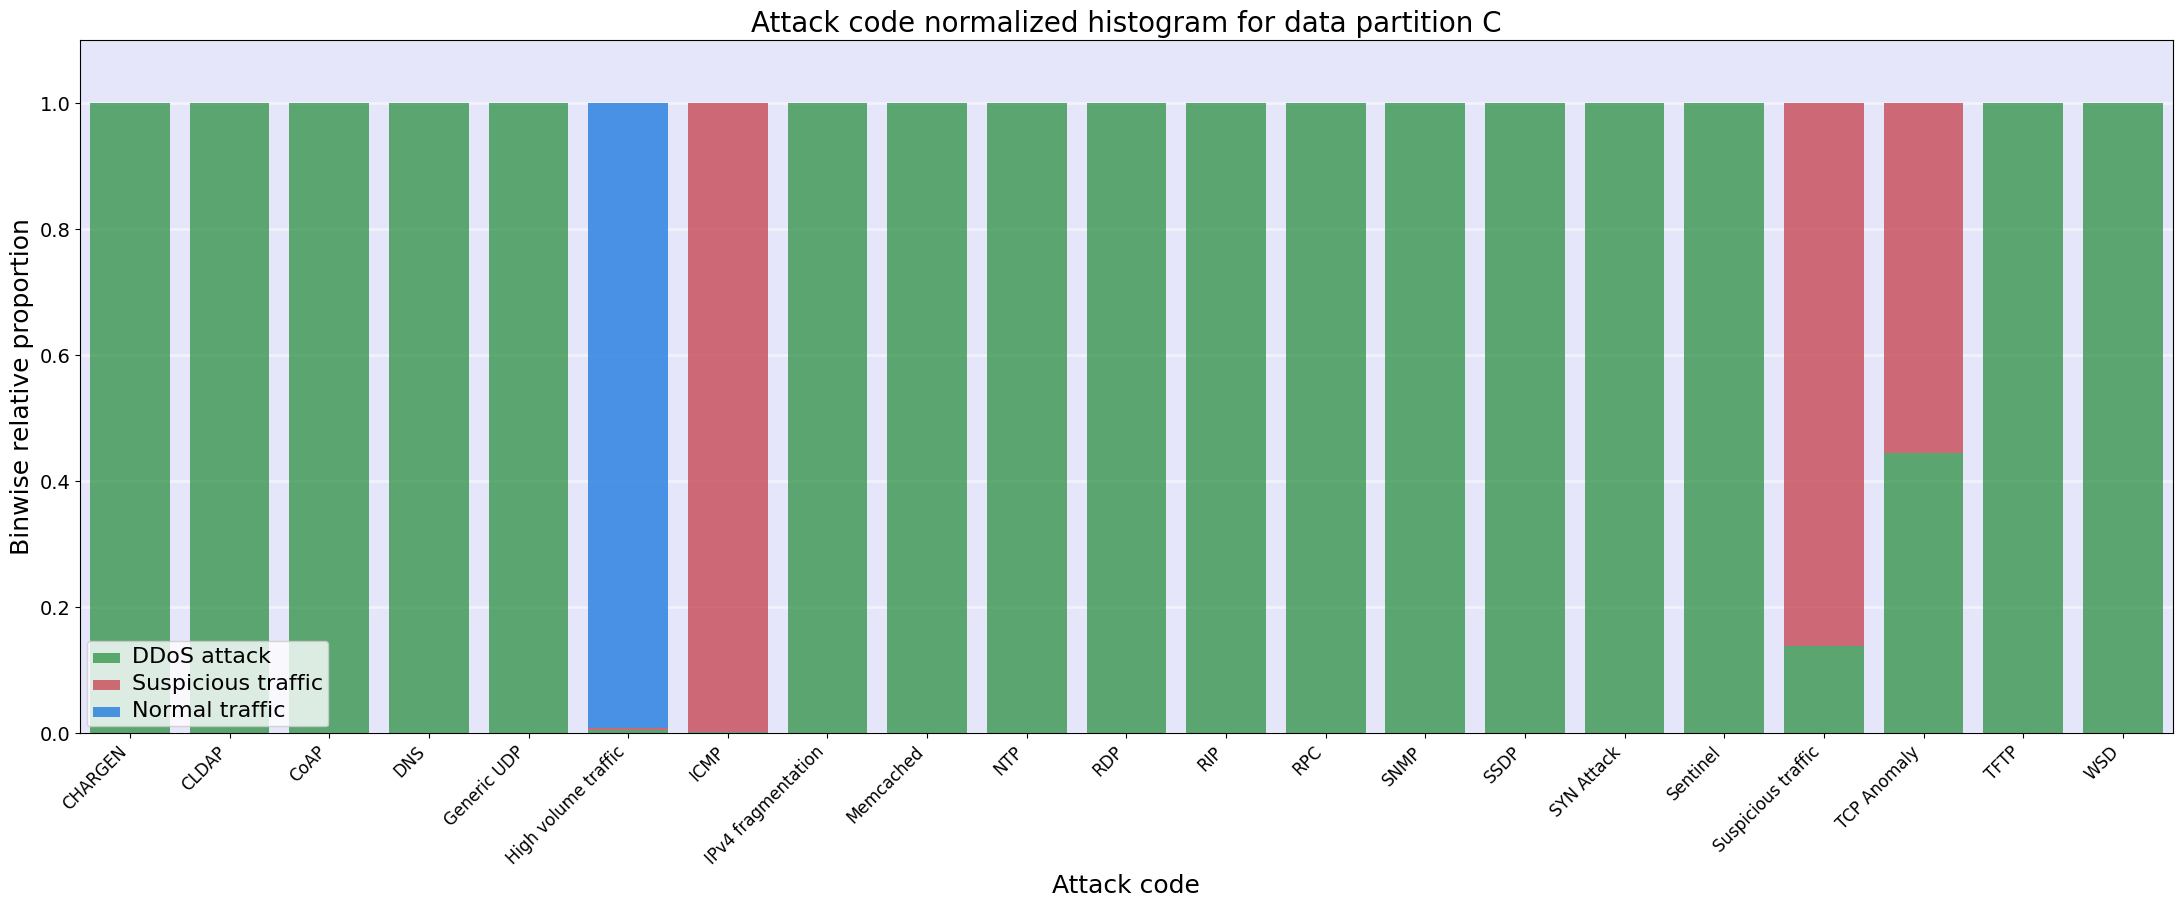

                     DDoS attack  Suspicious traffic  Normal traffic
ACK Attack              1.000000            0.000000        0.000000
CHARGEN                 1.000000            0.000000        0.000000
CLDAP                   1.000000            0.000000        0.000000
CoAP                    1.000000            0.000000        0.000000
DNS                     1.000000            0.000000        0.000000
Generic UDP             1.000000            0.000000        0.000000
High volume traffic     0.000454            0.003781        0.995764
ICMP                    1.000000            0.000000        0.000000
IPv4 fragmentation      1.000000            0.000000        0.000000
Memcached               1.000000            0.000000        0.000000
NTP                     1.000000            0.000000        0.000000
RDP                     1.000000            0.000000        0.000000
RPC                     1.000000            0.000000        0.000000
SNMP                    1.000000  

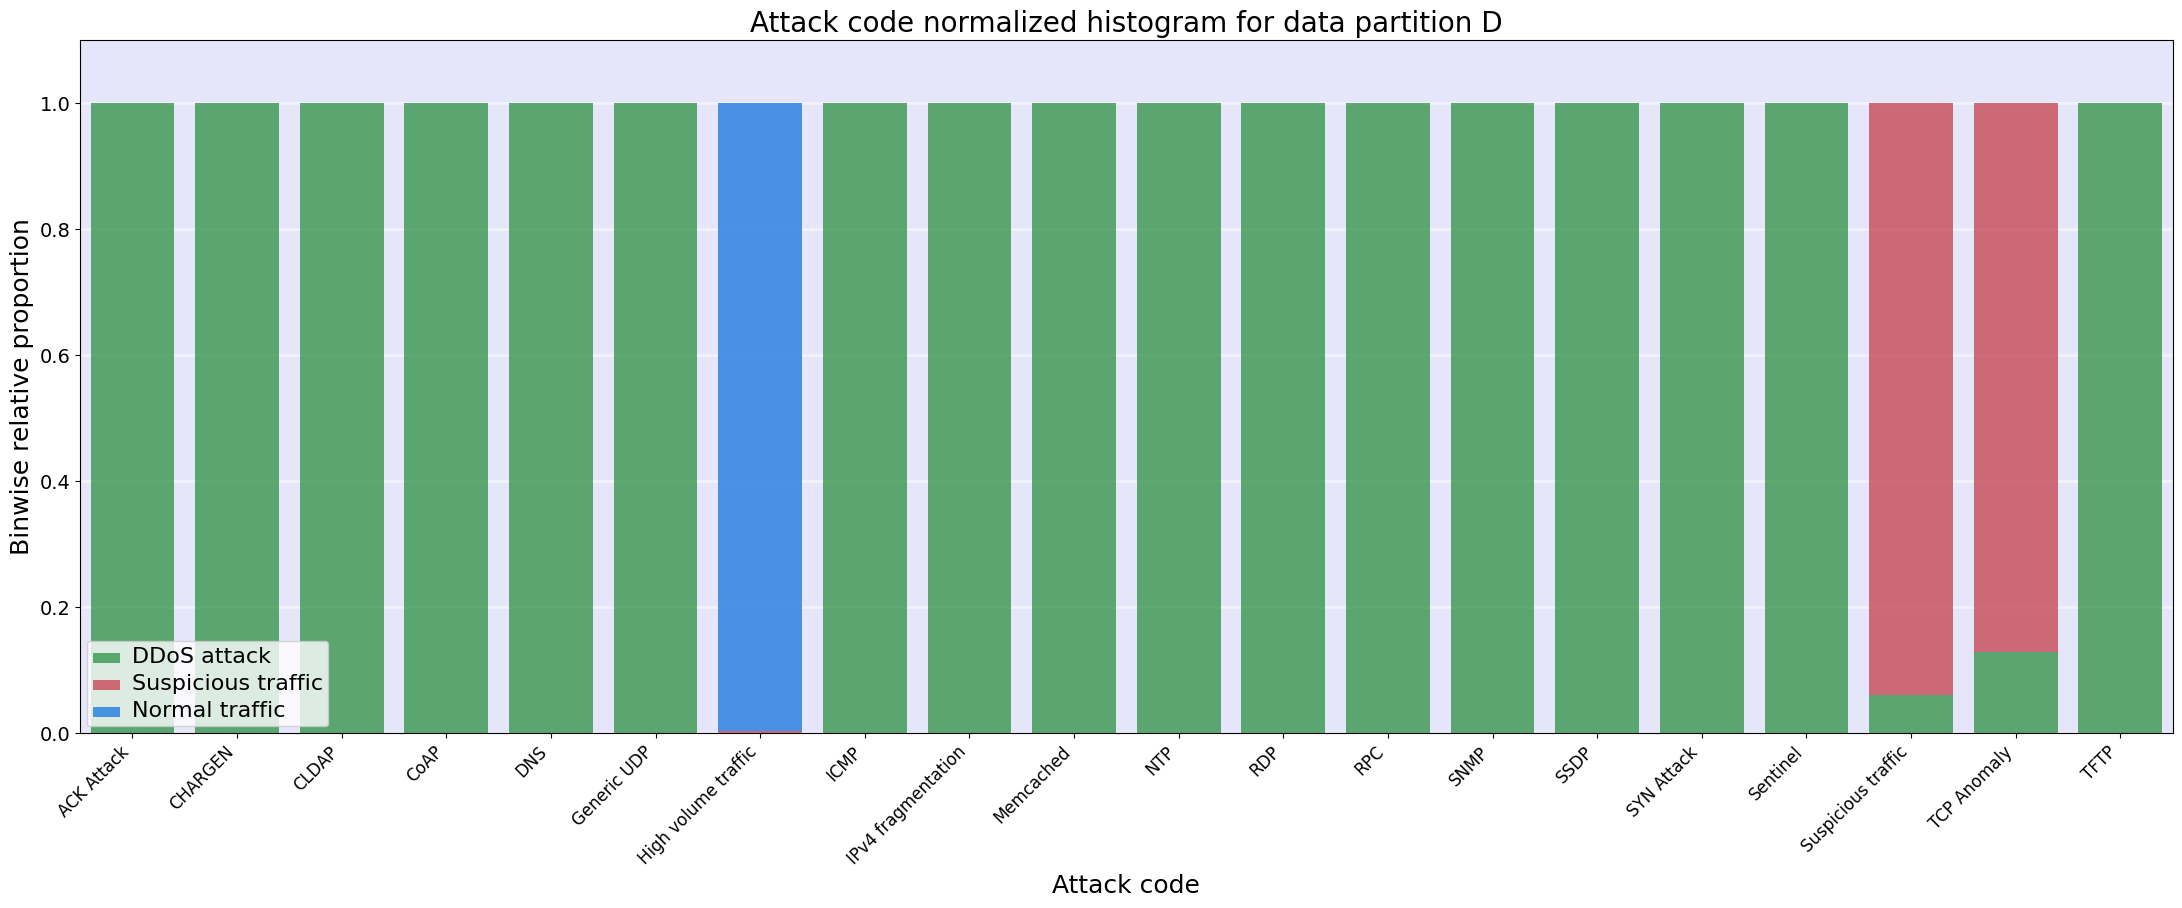

In [33]:
partition_a = DataPartition('A')
partition_b = DataPartition('B')
partition_c = DataPartition('C')
partition_d = DataPartition('D')

partition_a.create_normalized_histogram_for_events('Avg source IP count', save=True)
partition_b.create_normalized_histogram_for_events('Avg source IP count', save=True)
partition_c.create_normalized_histogram_for_events('Avg source IP count', save=True)
partition_d.create_normalized_histogram_for_events('Avg source IP count', save=True)

partition_a.create_normalized_histogram_for_events('Data speed', save=True)
partition_b.create_normalized_histogram_for_events('Data speed', save=True)
partition_c.create_normalized_histogram_for_events('Data speed', save=True)
partition_d.create_normalized_histogram_for_events('Data speed', save=True)

partition_a.create_normalized_histogram_for_attack_code(save=True)
partition_b.create_normalized_histogram_for_attack_code(save=True)
partition_c.create_normalized_histogram_for_attack_code(save=True)
partition_d.create_normalized_histogram_for_attack_code(save=True)

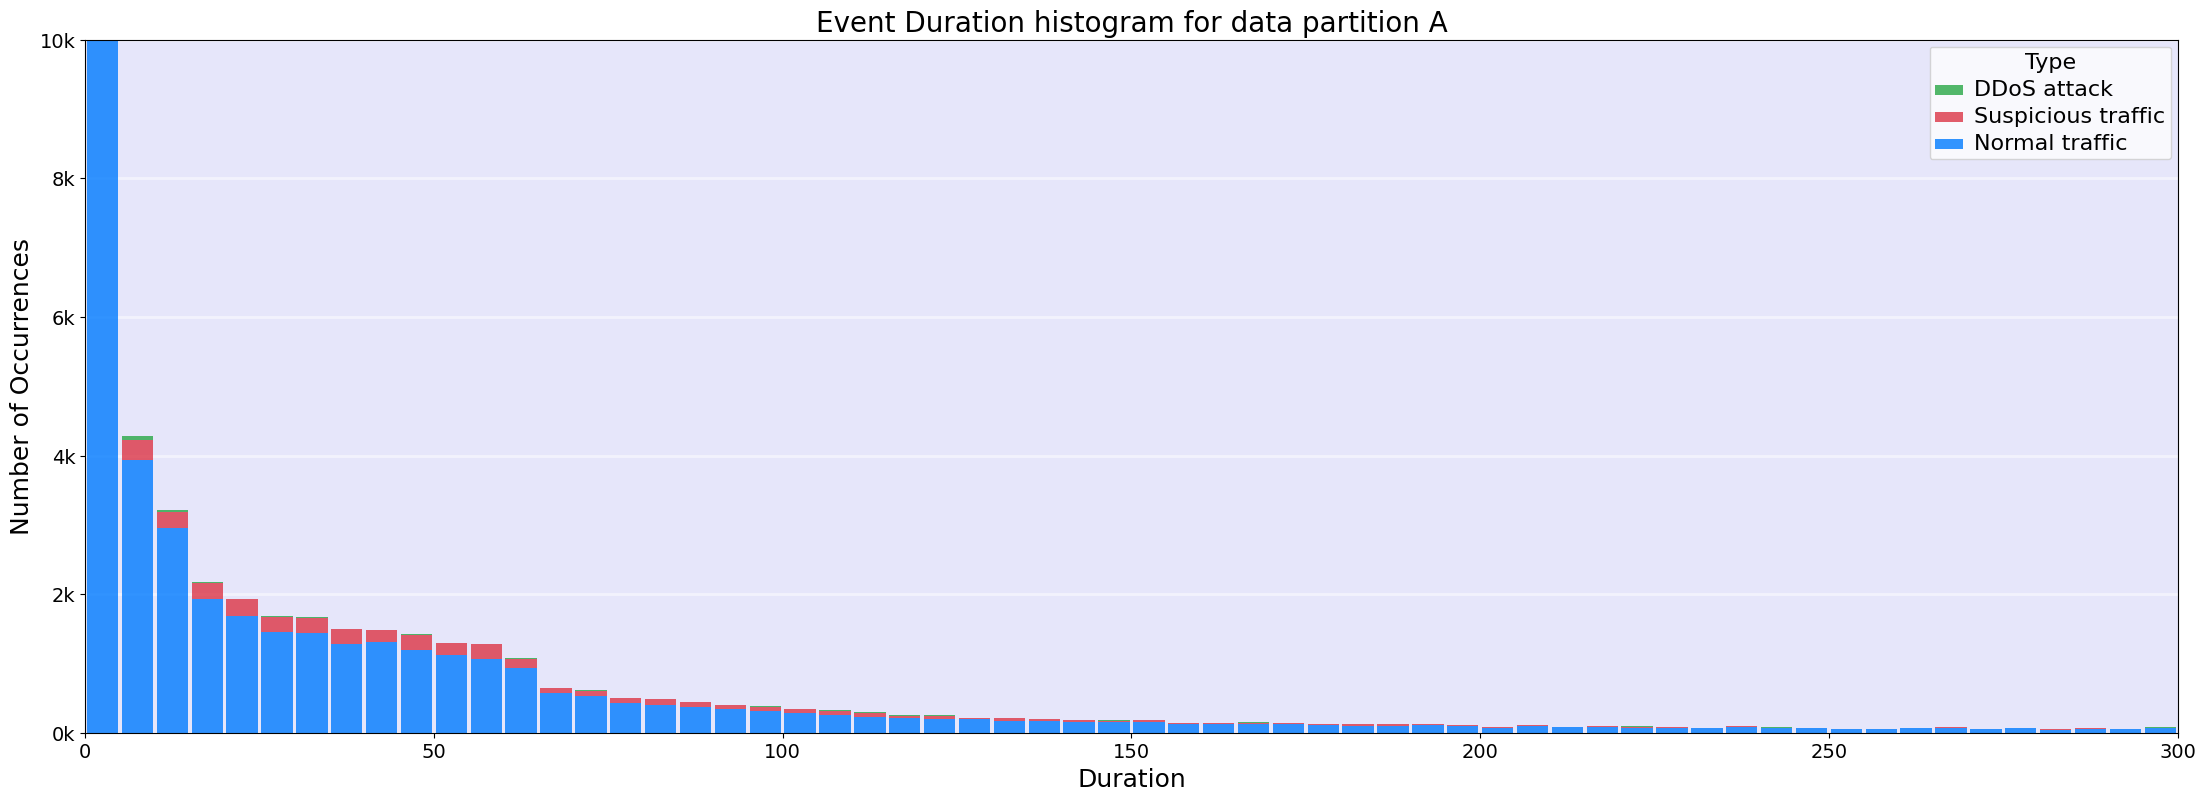

/tmp/ipykernel_729/3597966466.py:148: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = data.groupby(['bin', 'Type']).size().unstack(fill_value=0)


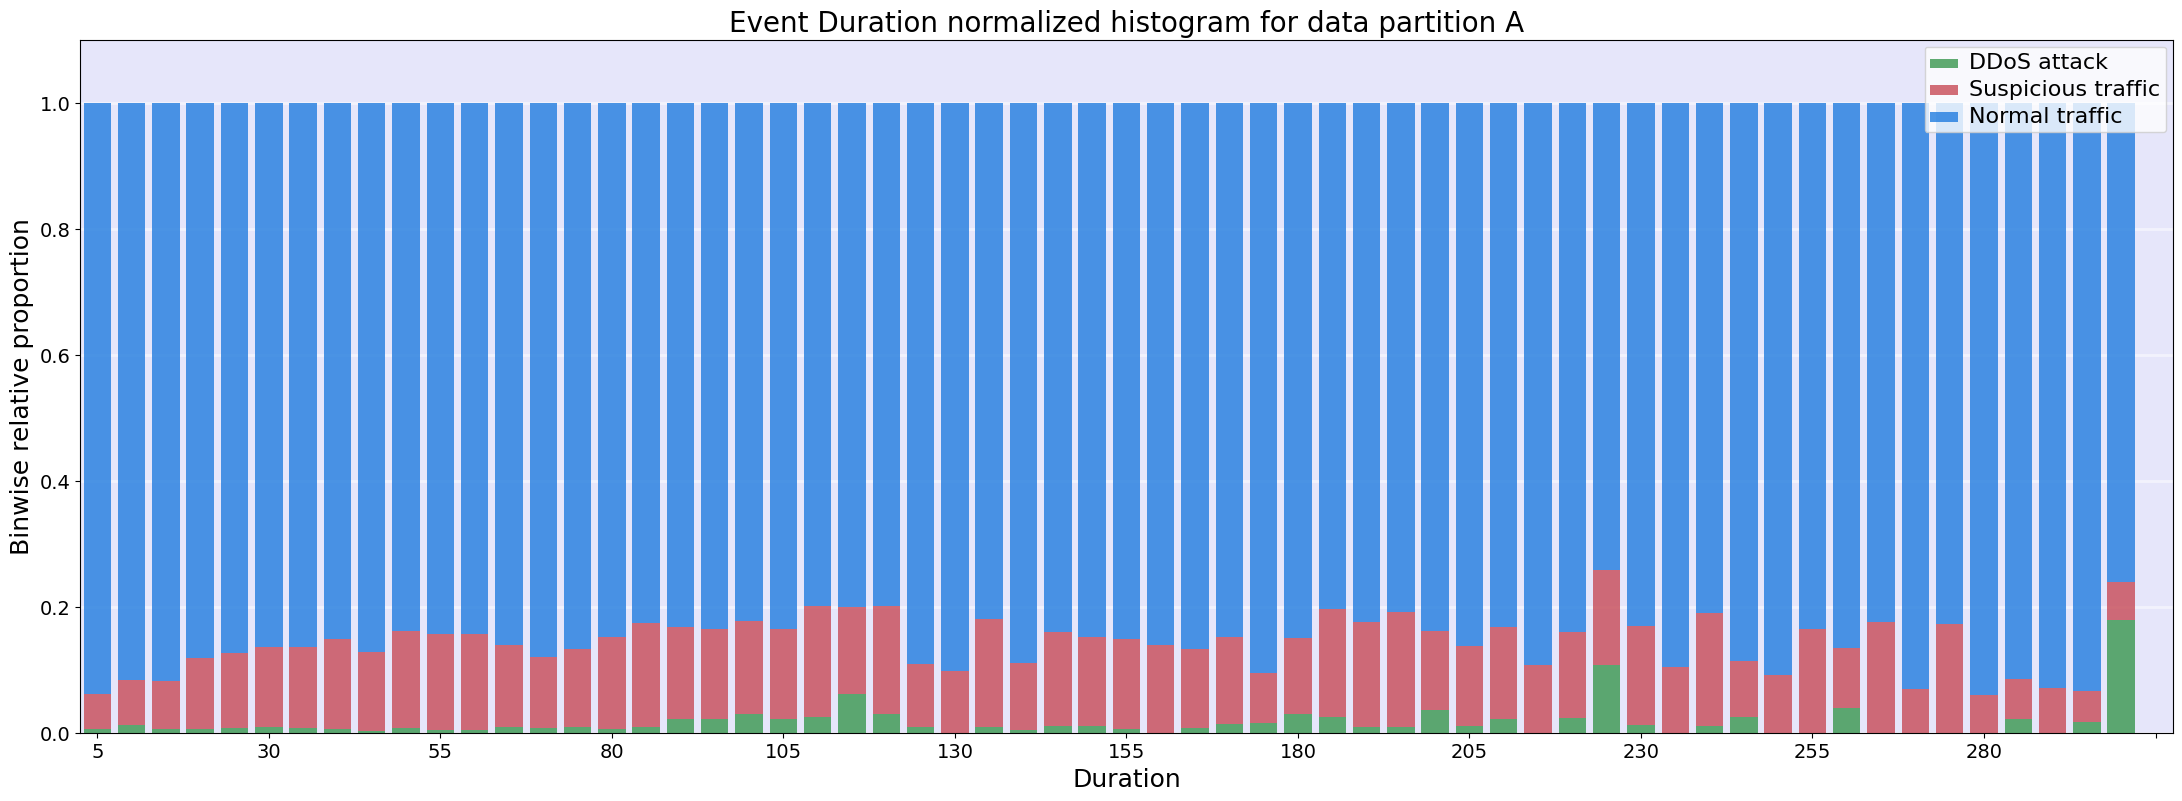

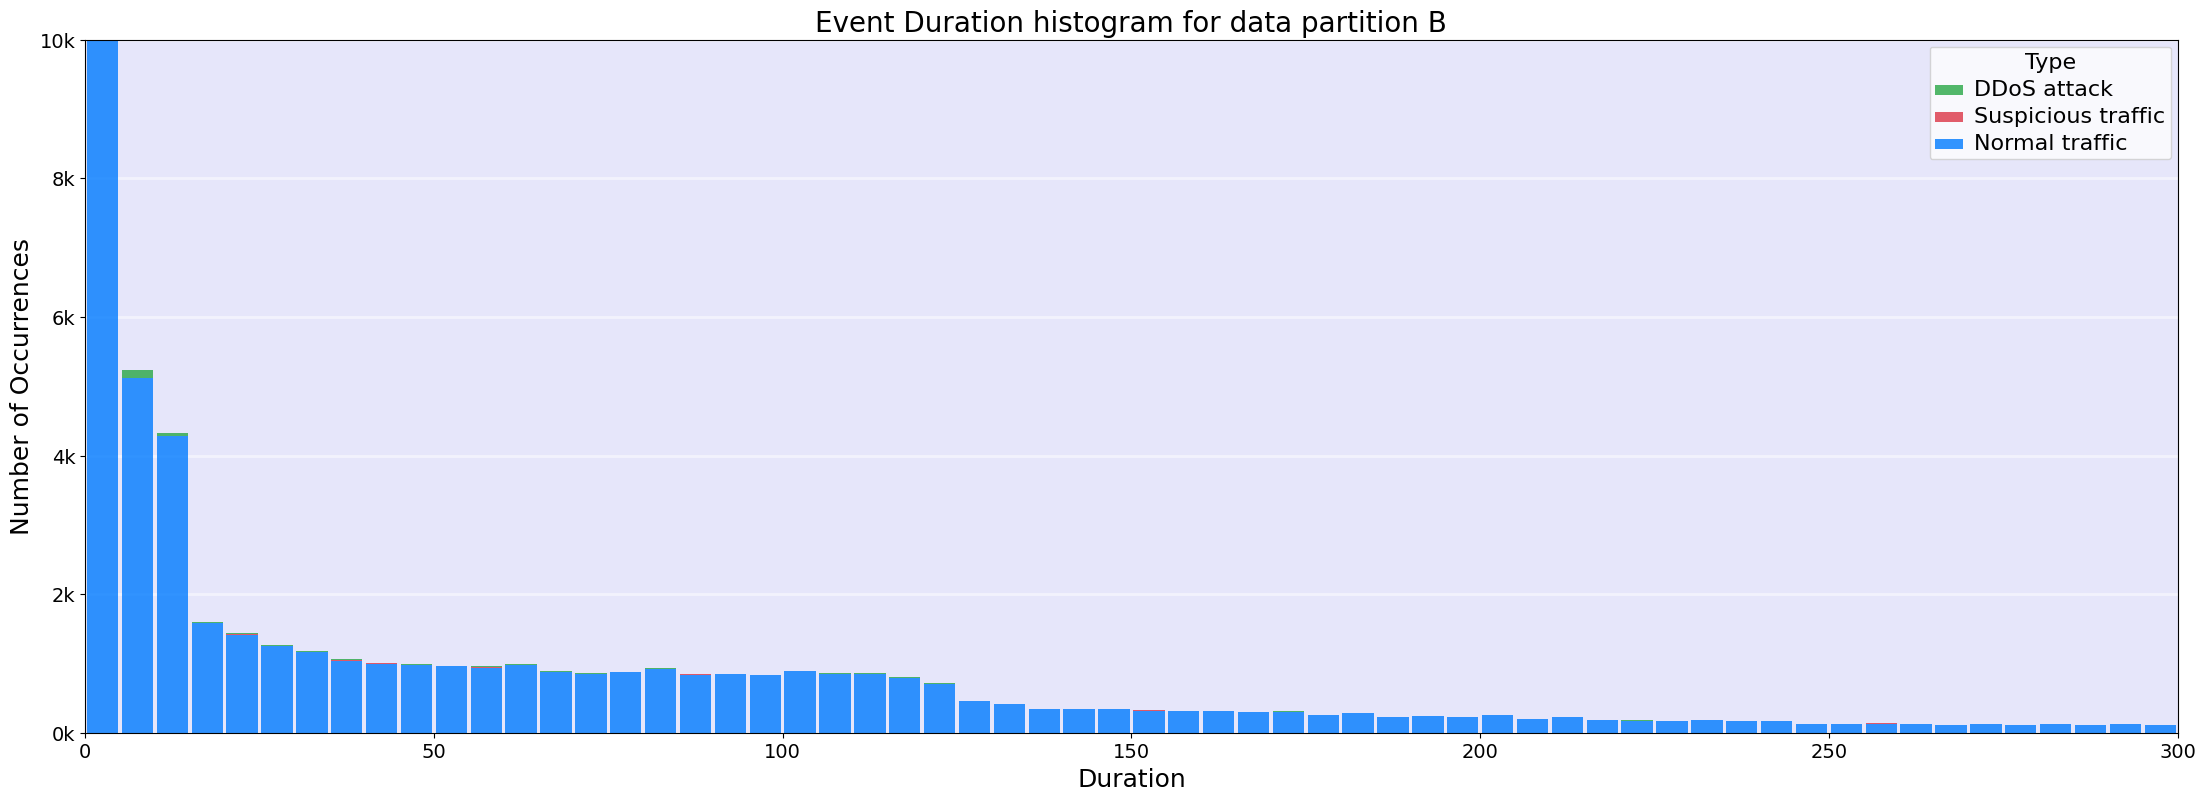

/tmp/ipykernel_729/3597966466.py:148: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = data.groupby(['bin', 'Type']).size().unstack(fill_value=0)


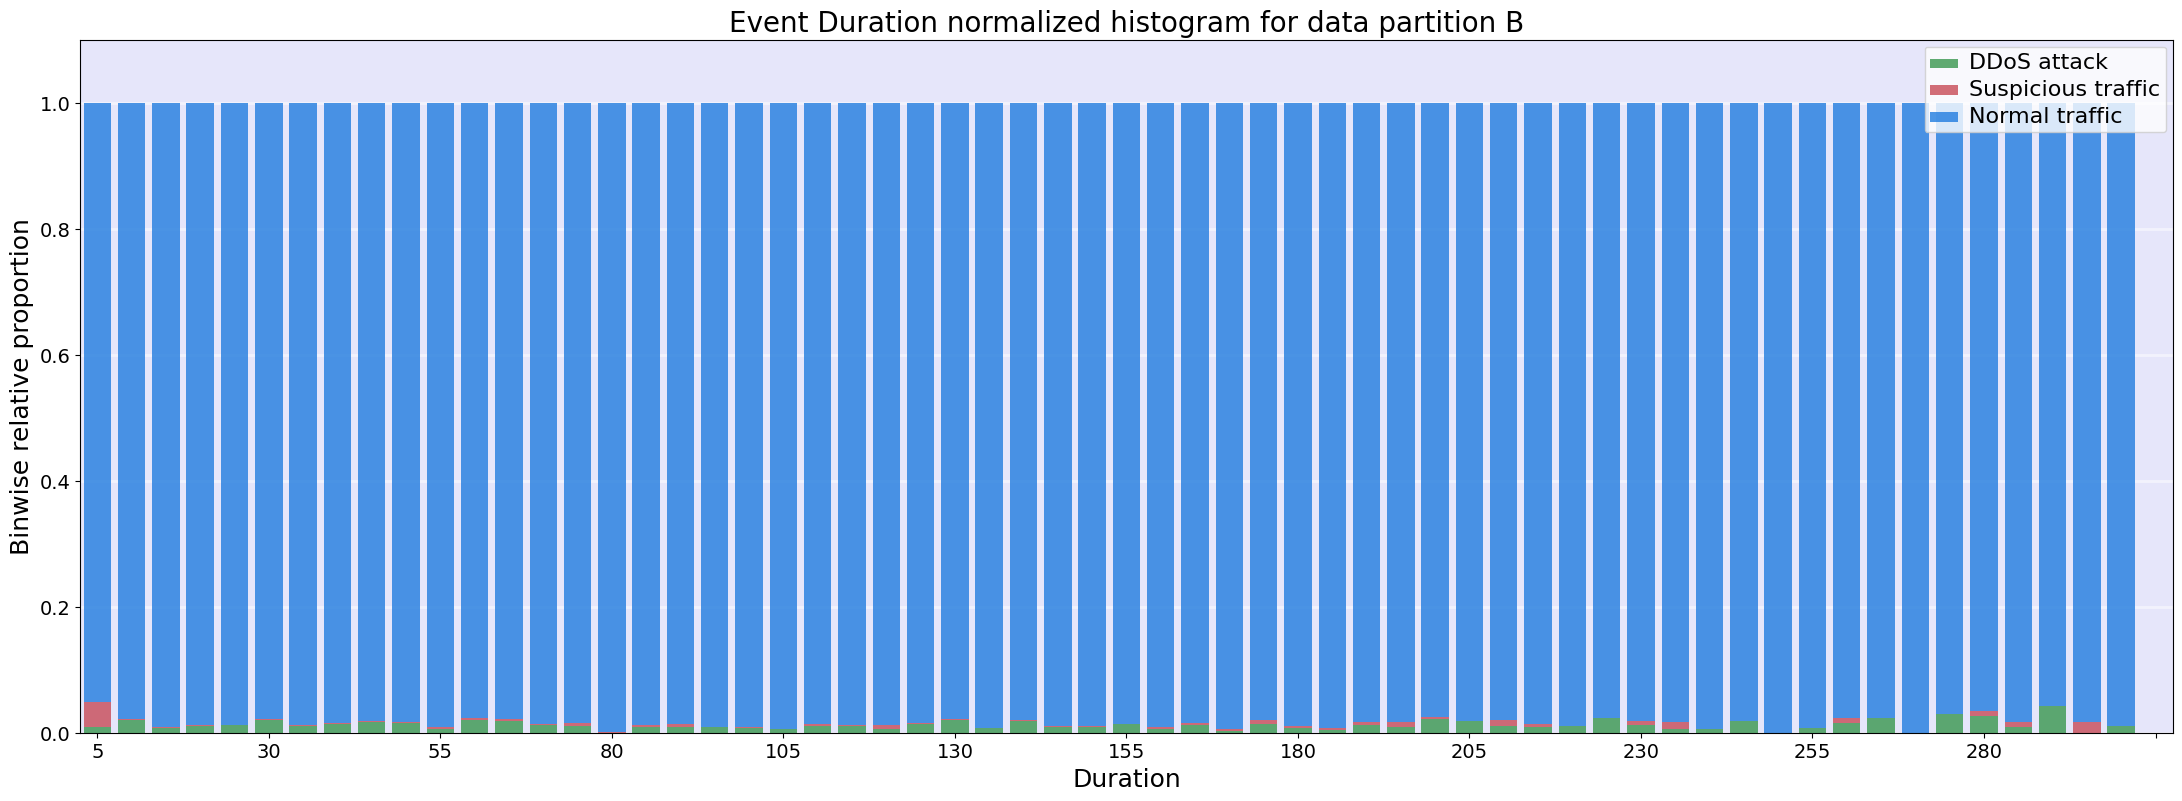

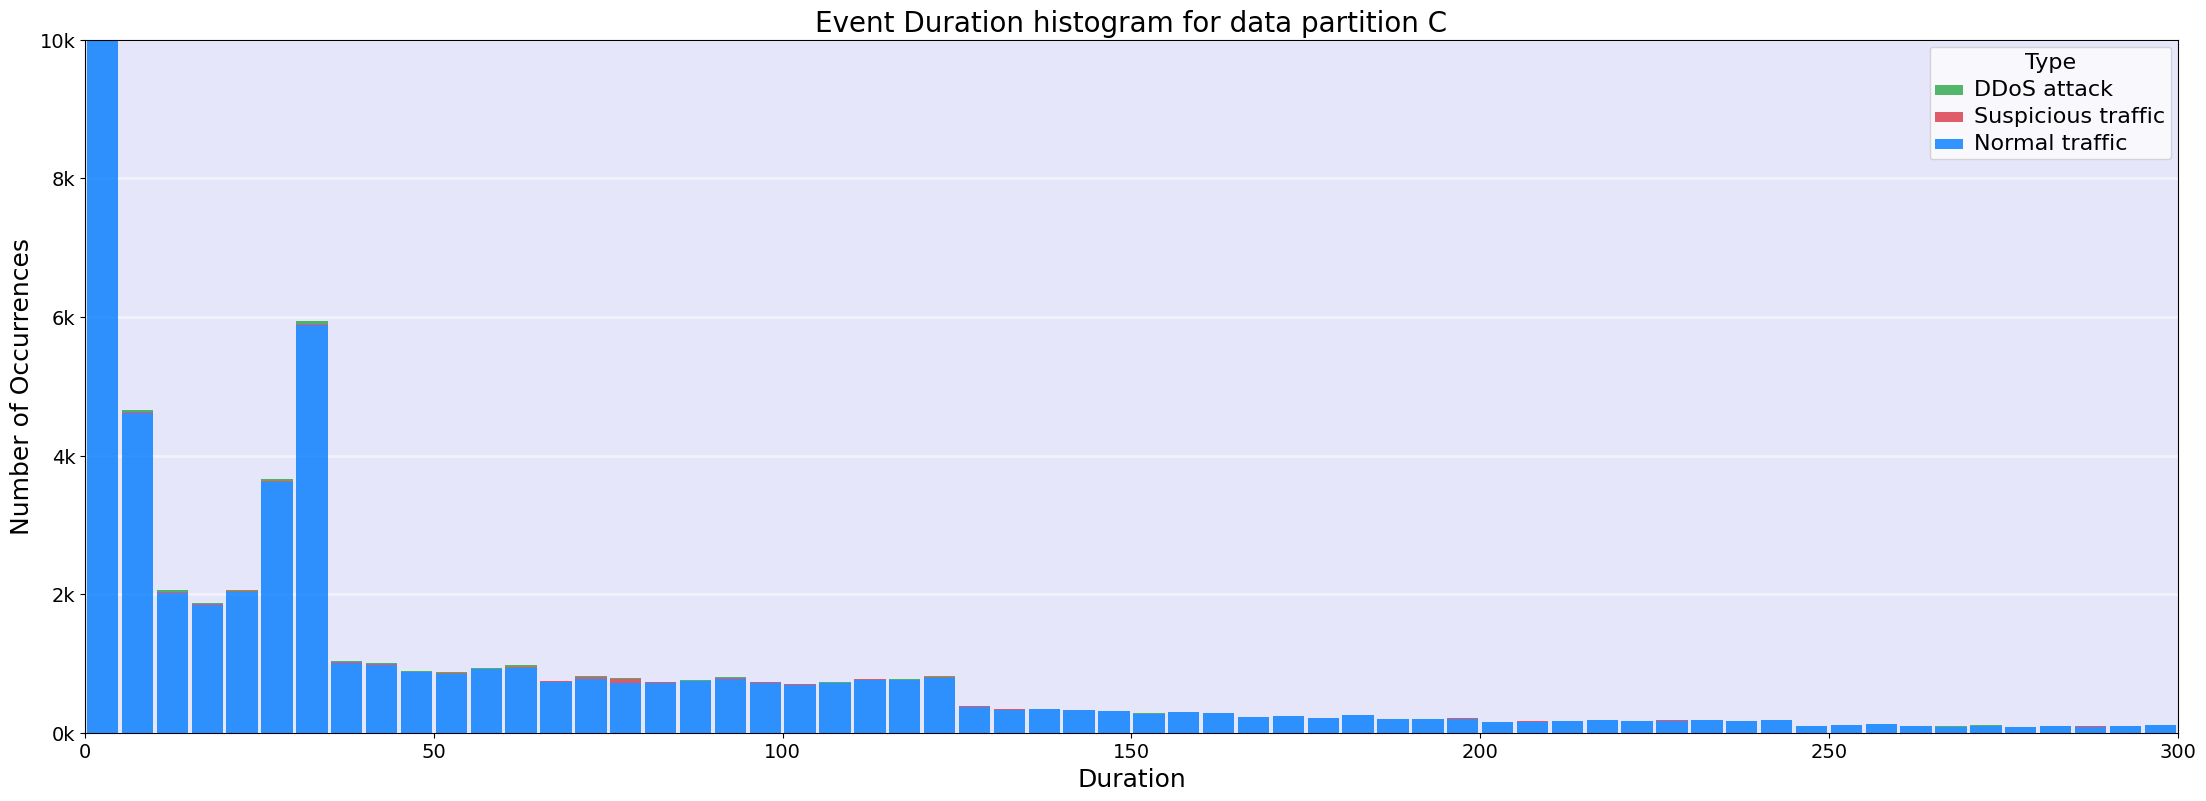

/tmp/ipykernel_729/3597966466.py:148: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = data.groupby(['bin', 'Type']).size().unstack(fill_value=0)


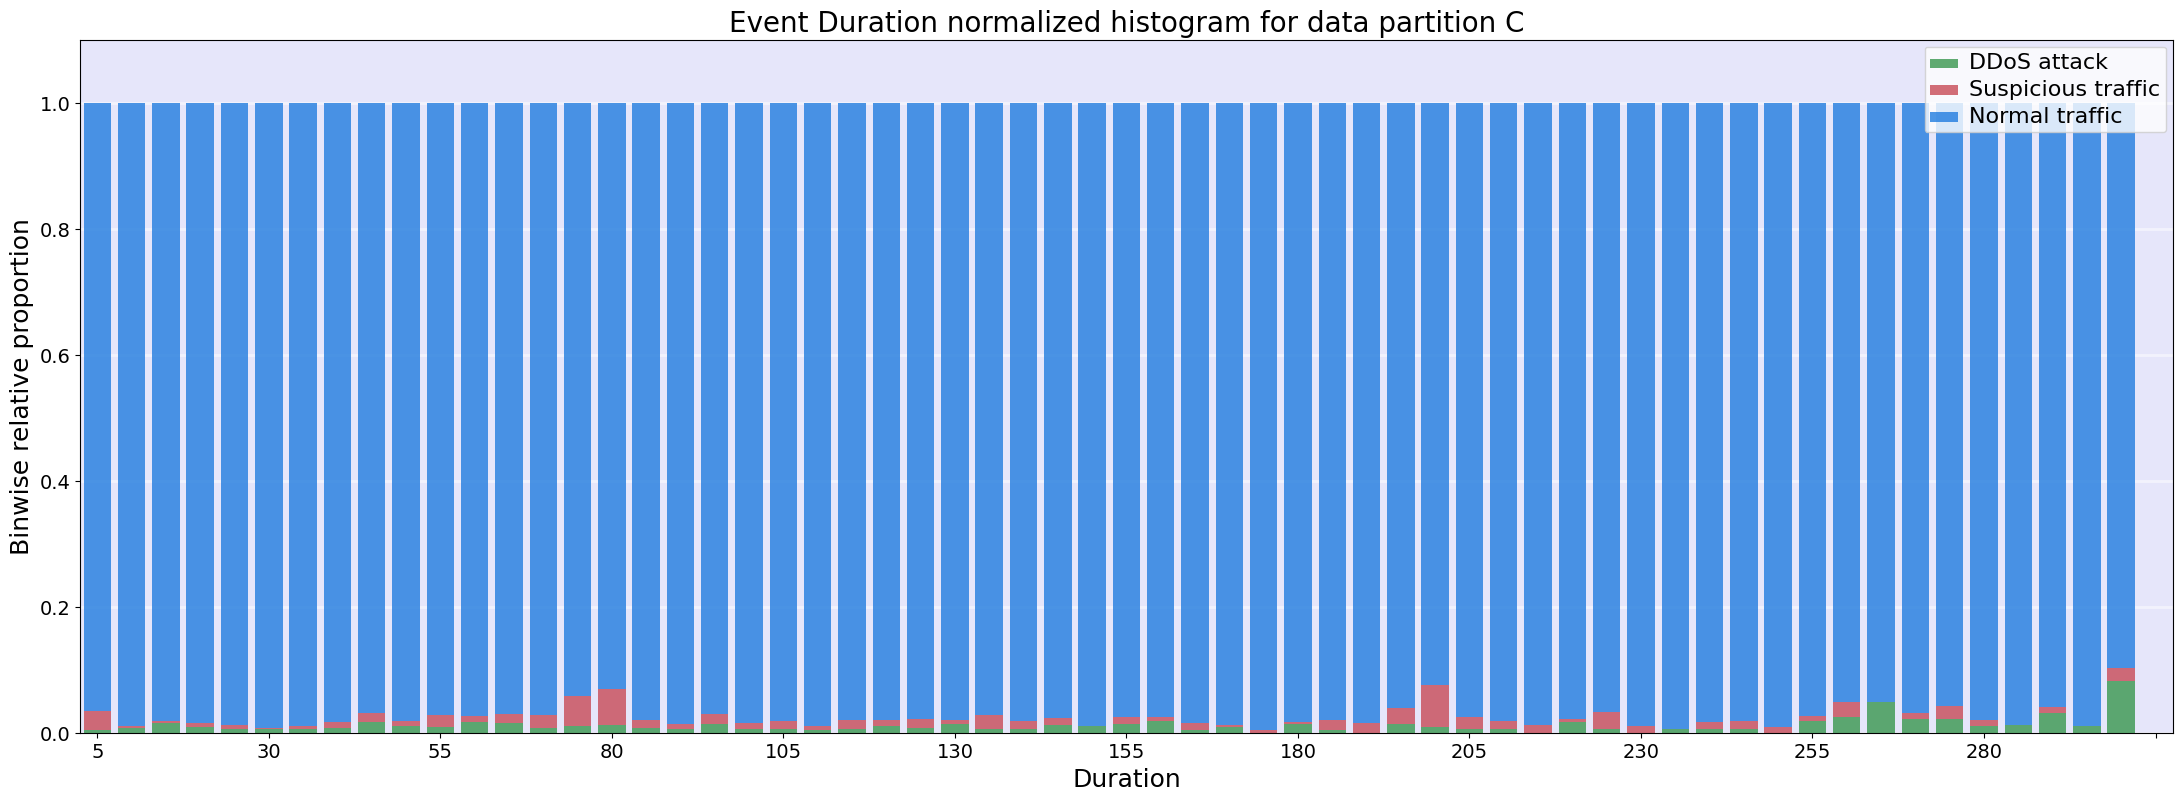

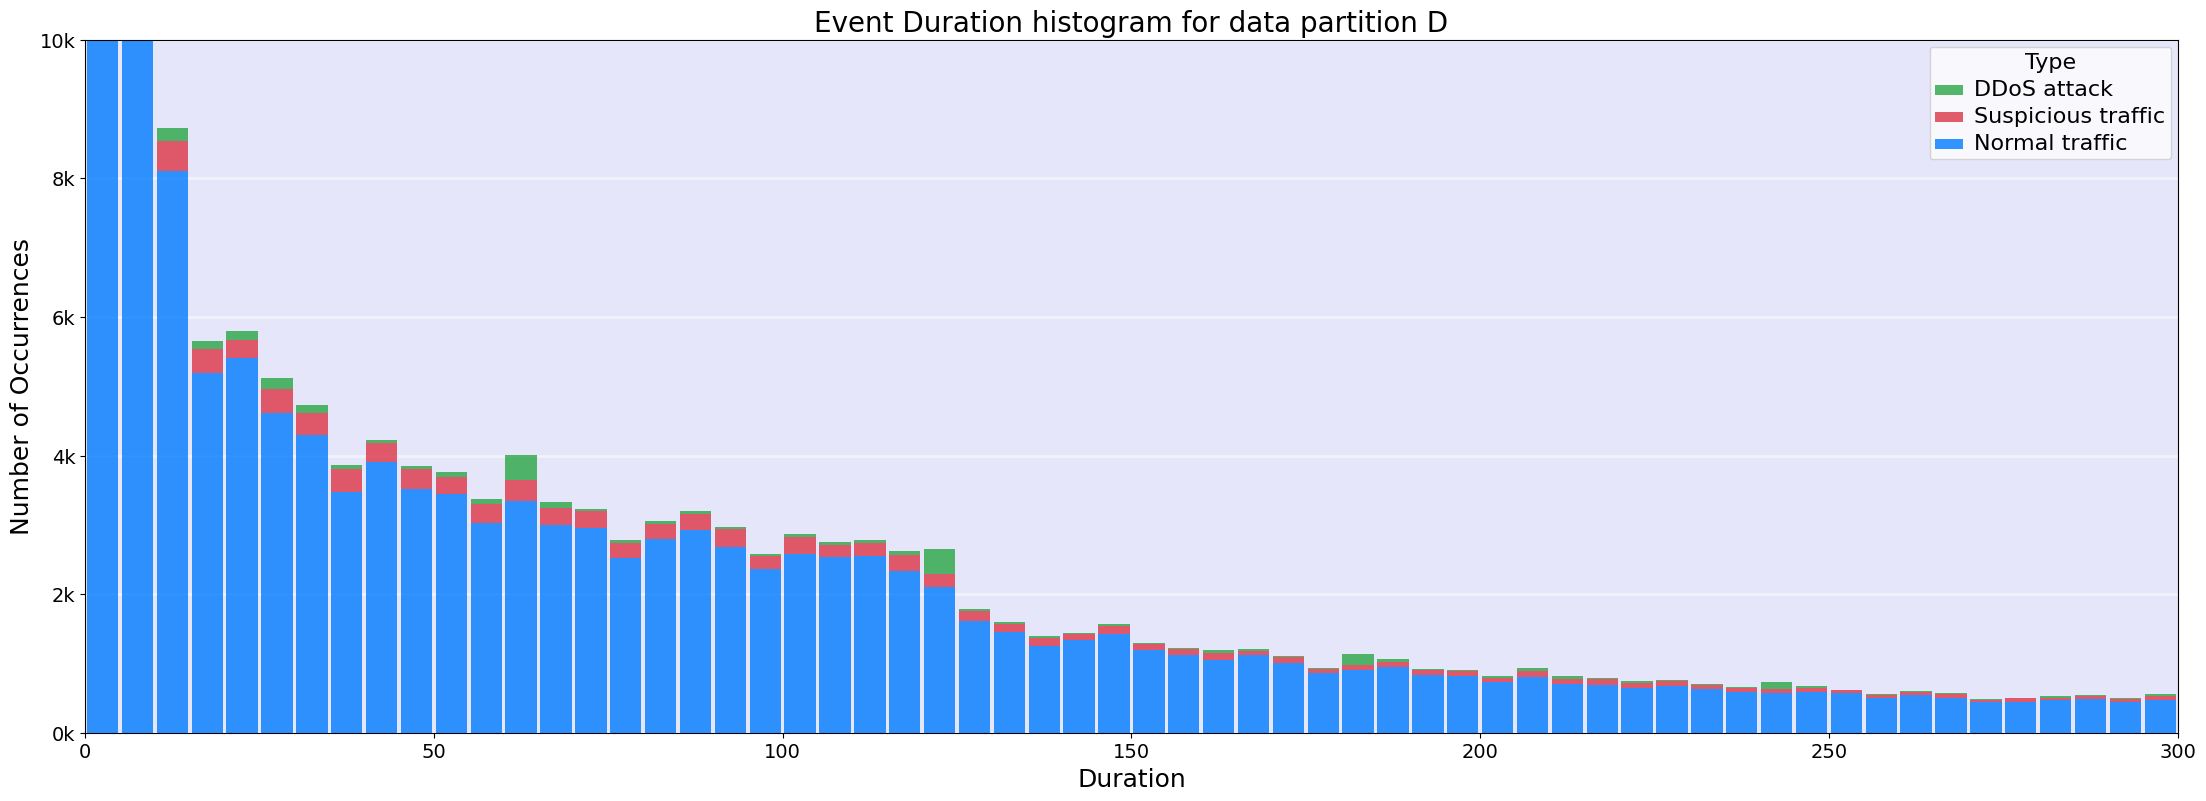

/tmp/ipykernel_729/3597966466.py:148: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = data.groupby(['bin', 'Type']).size().unstack(fill_value=0)


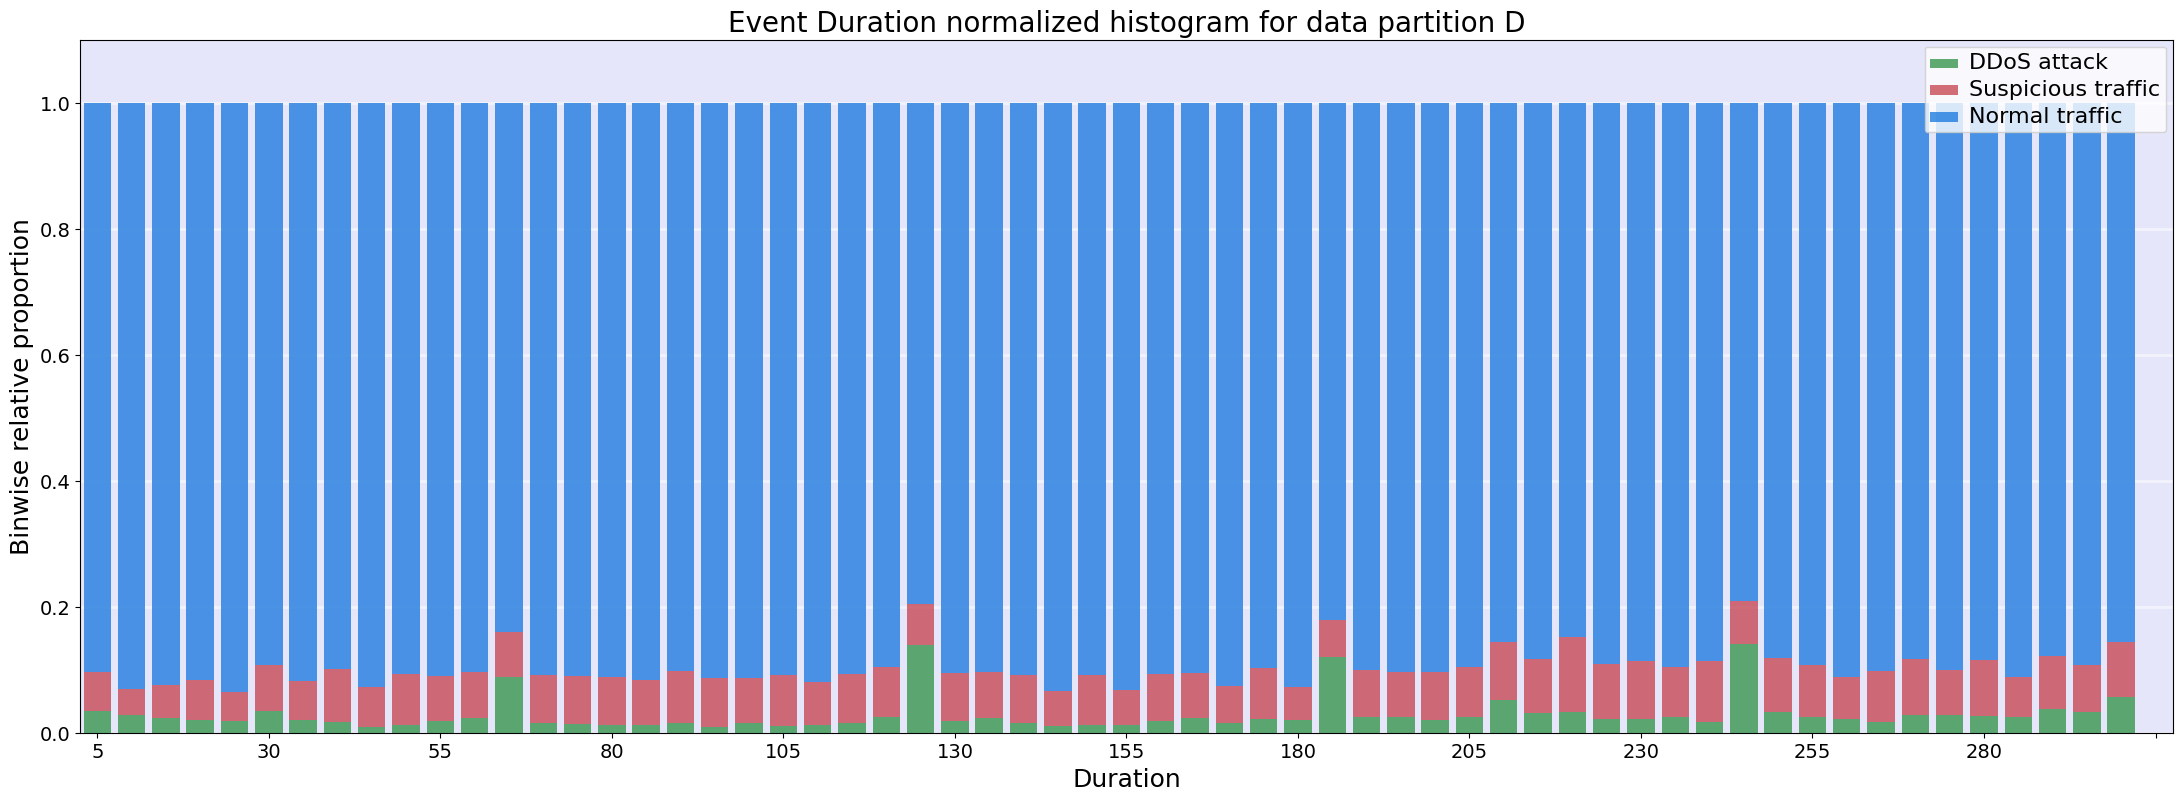

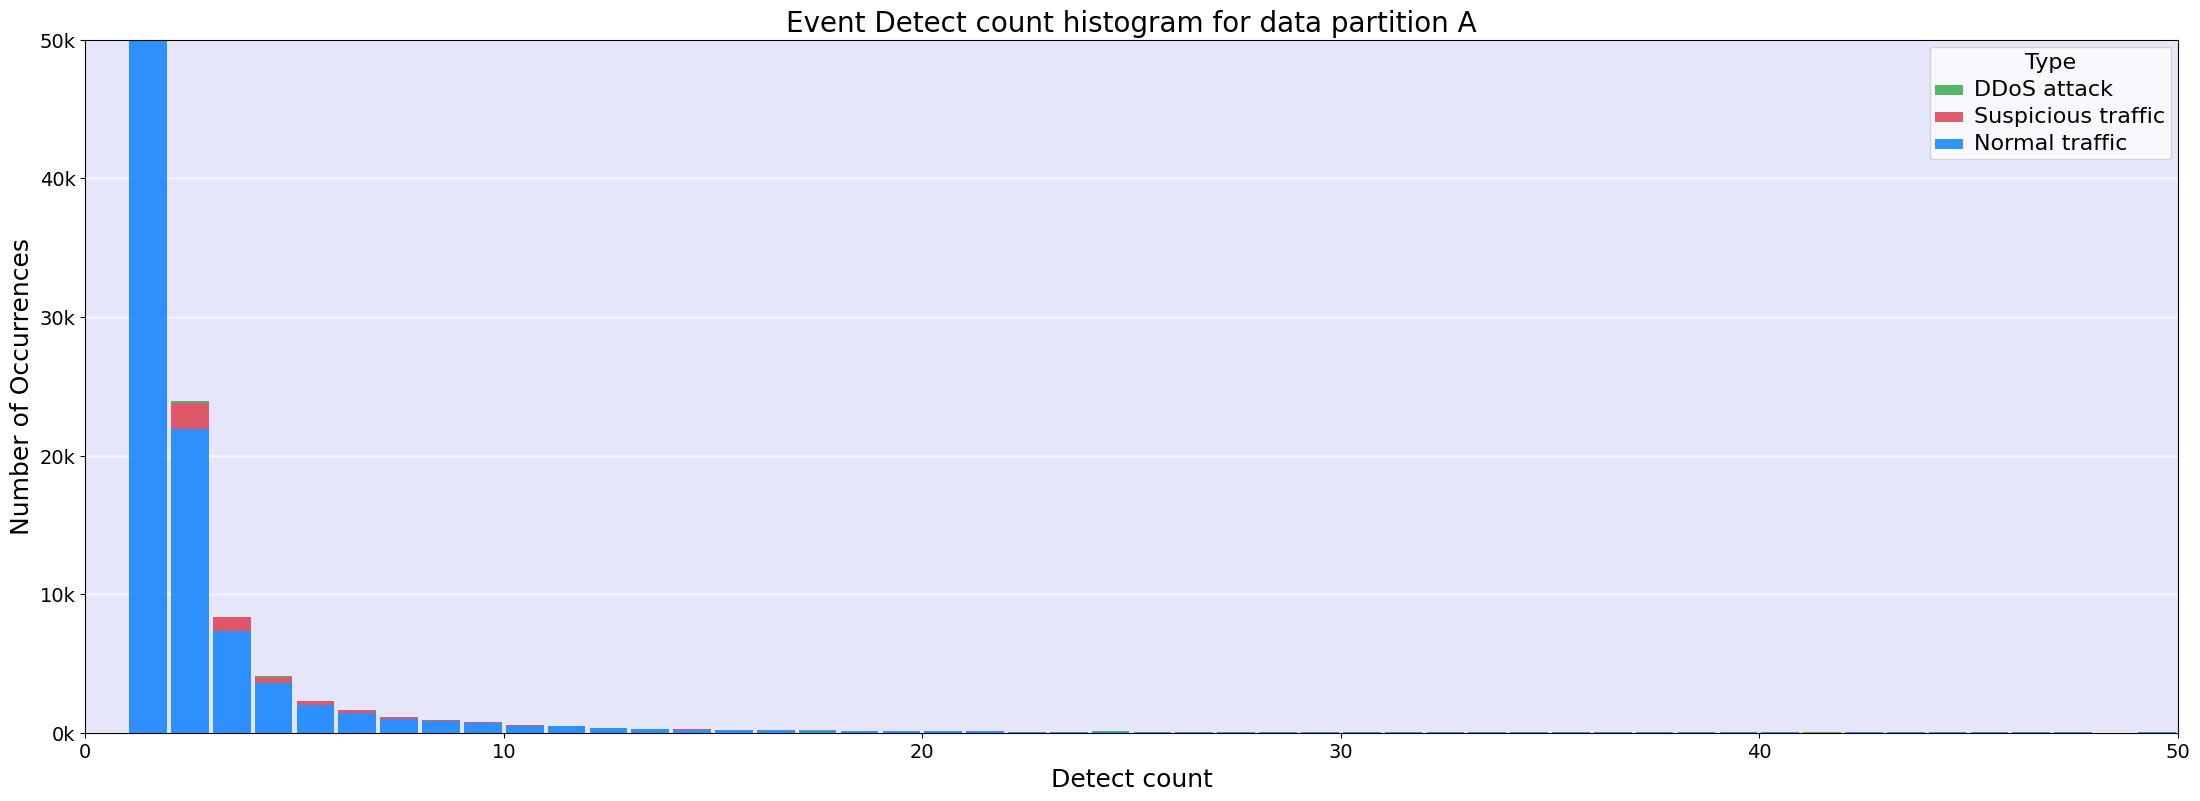

/tmp/ipykernel_729/3597966466.py:148: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = data.groupby(['bin', 'Type']).size().unstack(fill_value=0)


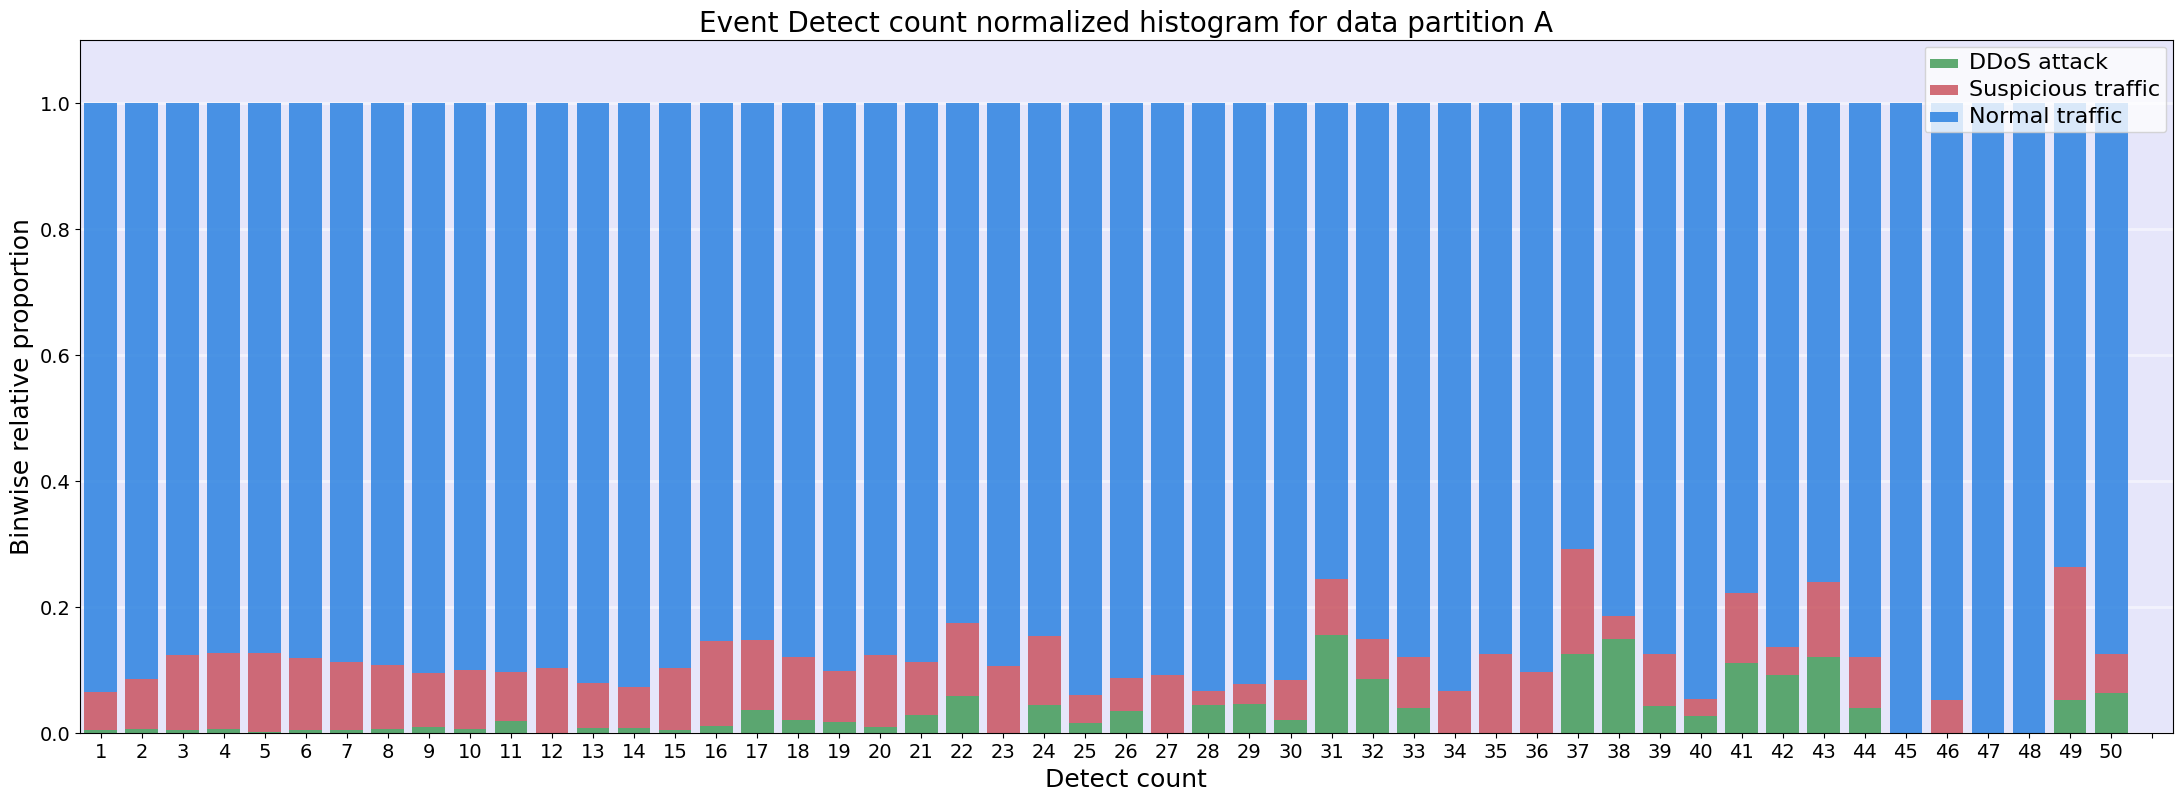

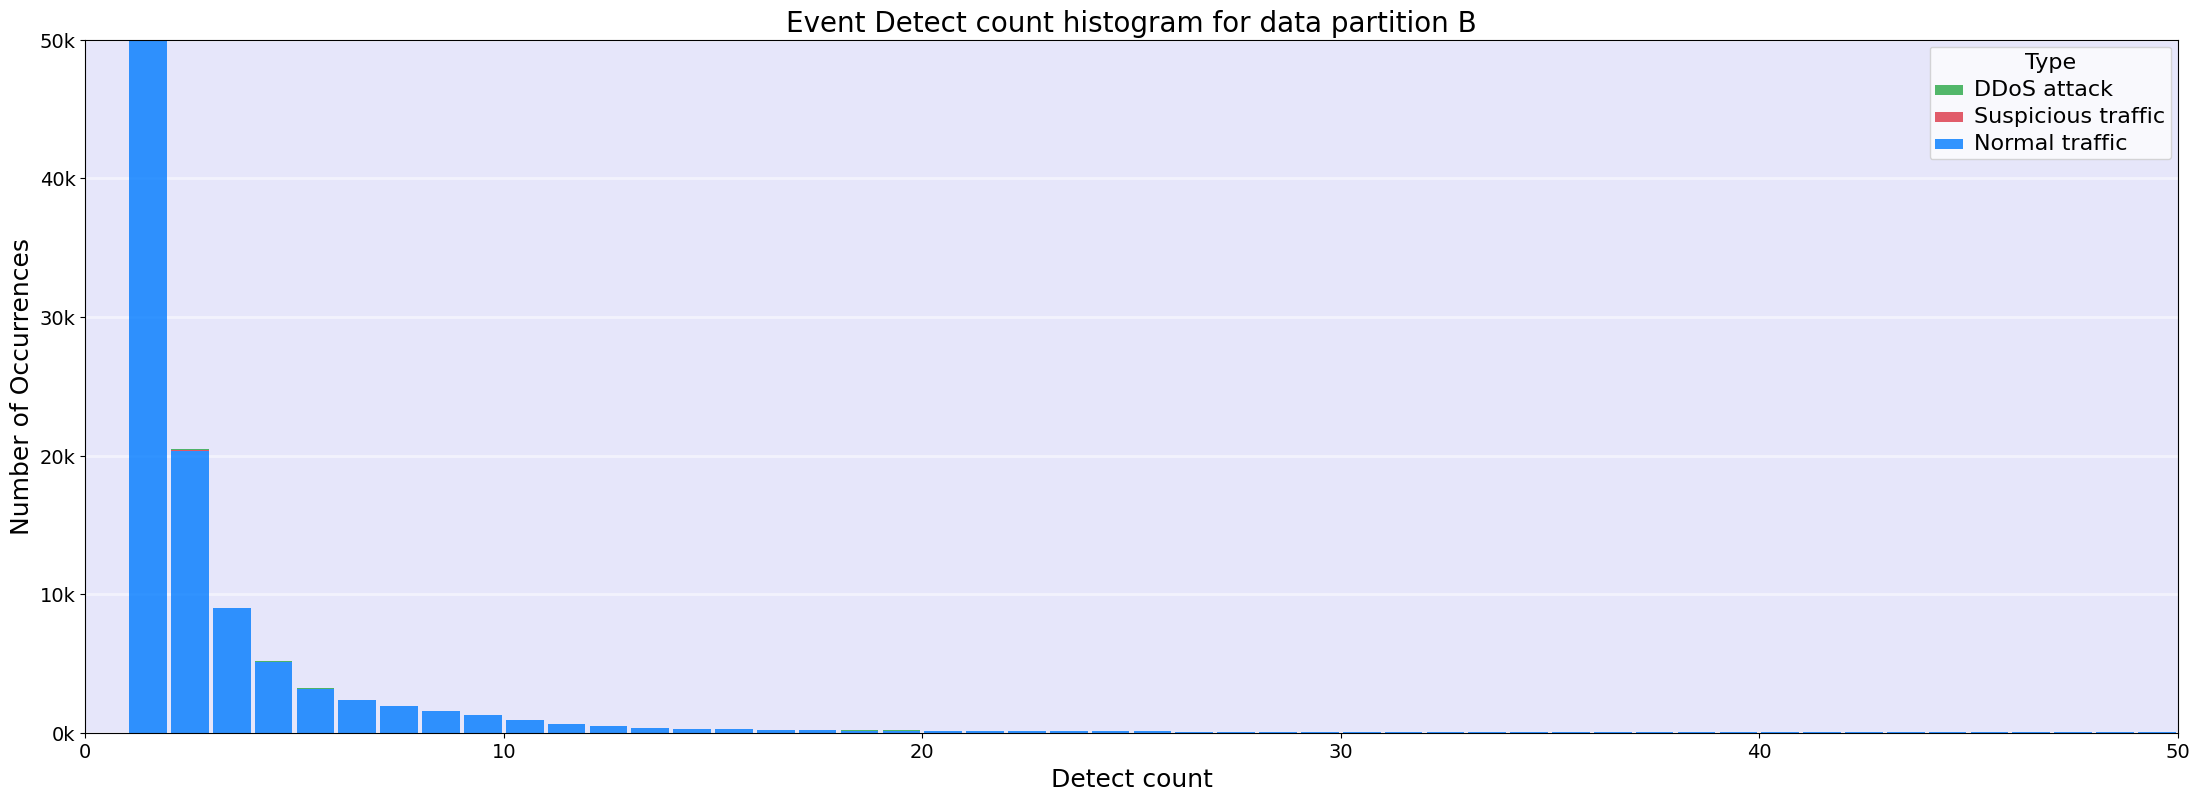

/tmp/ipykernel_729/3597966466.py:148: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = data.groupby(['bin', 'Type']).size().unstack(fill_value=0)


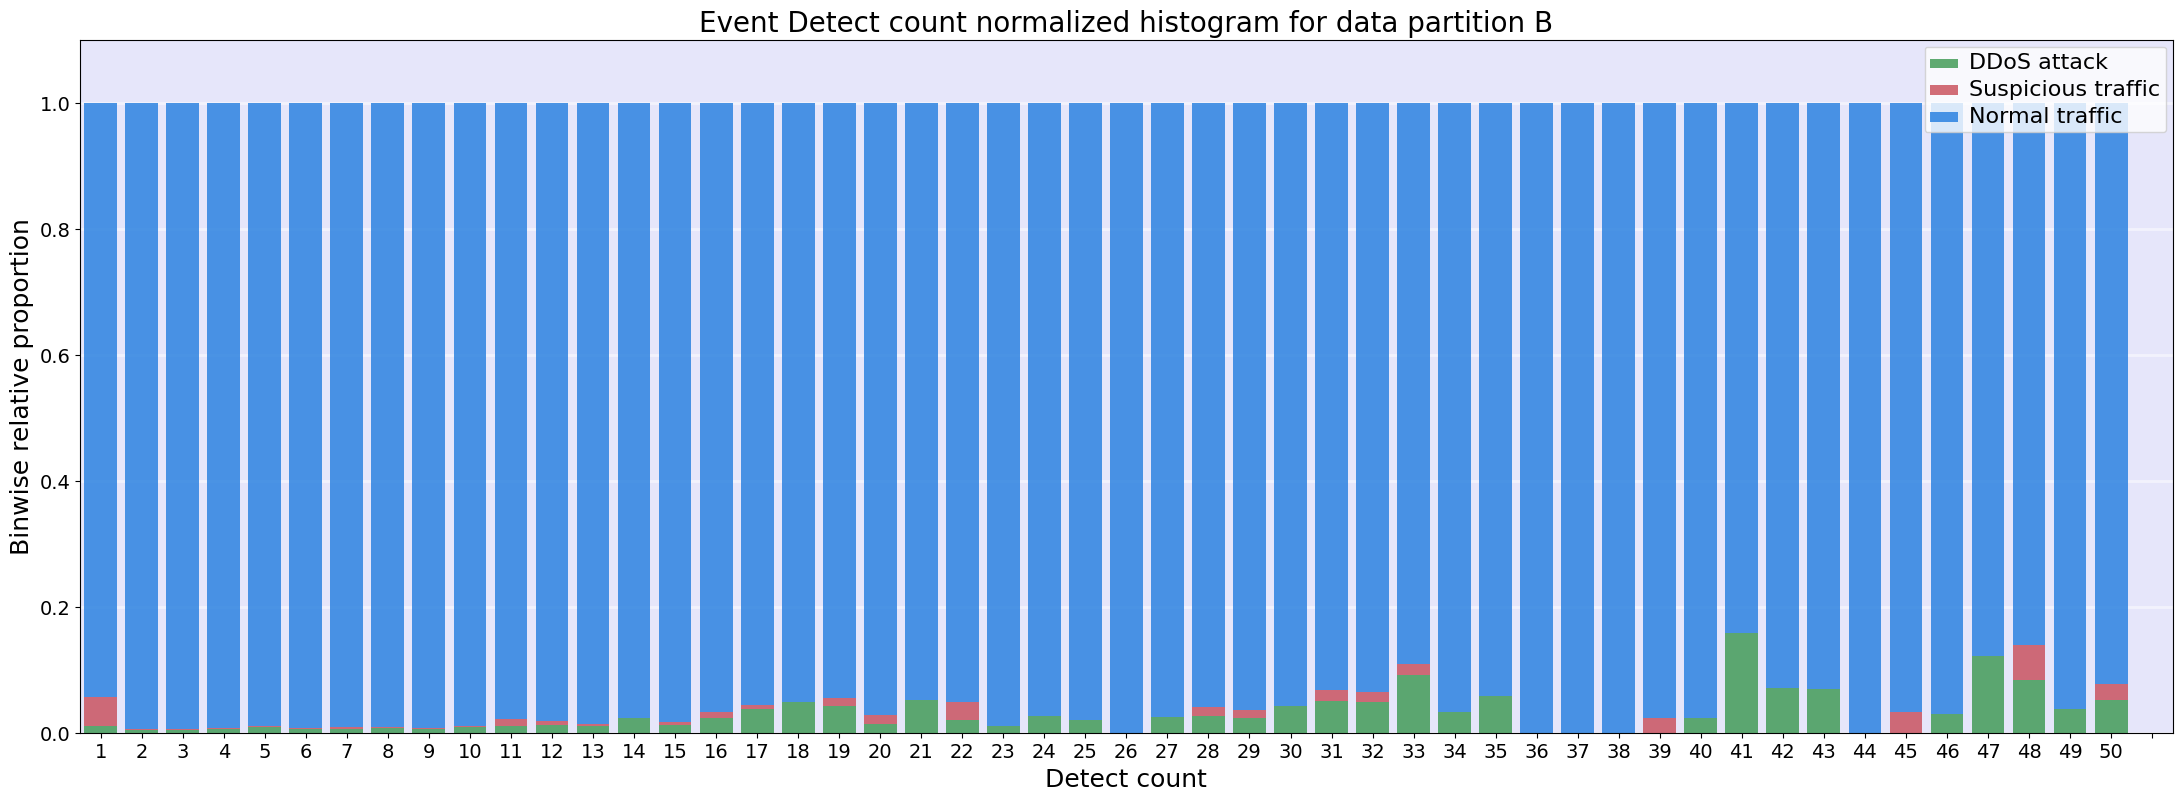

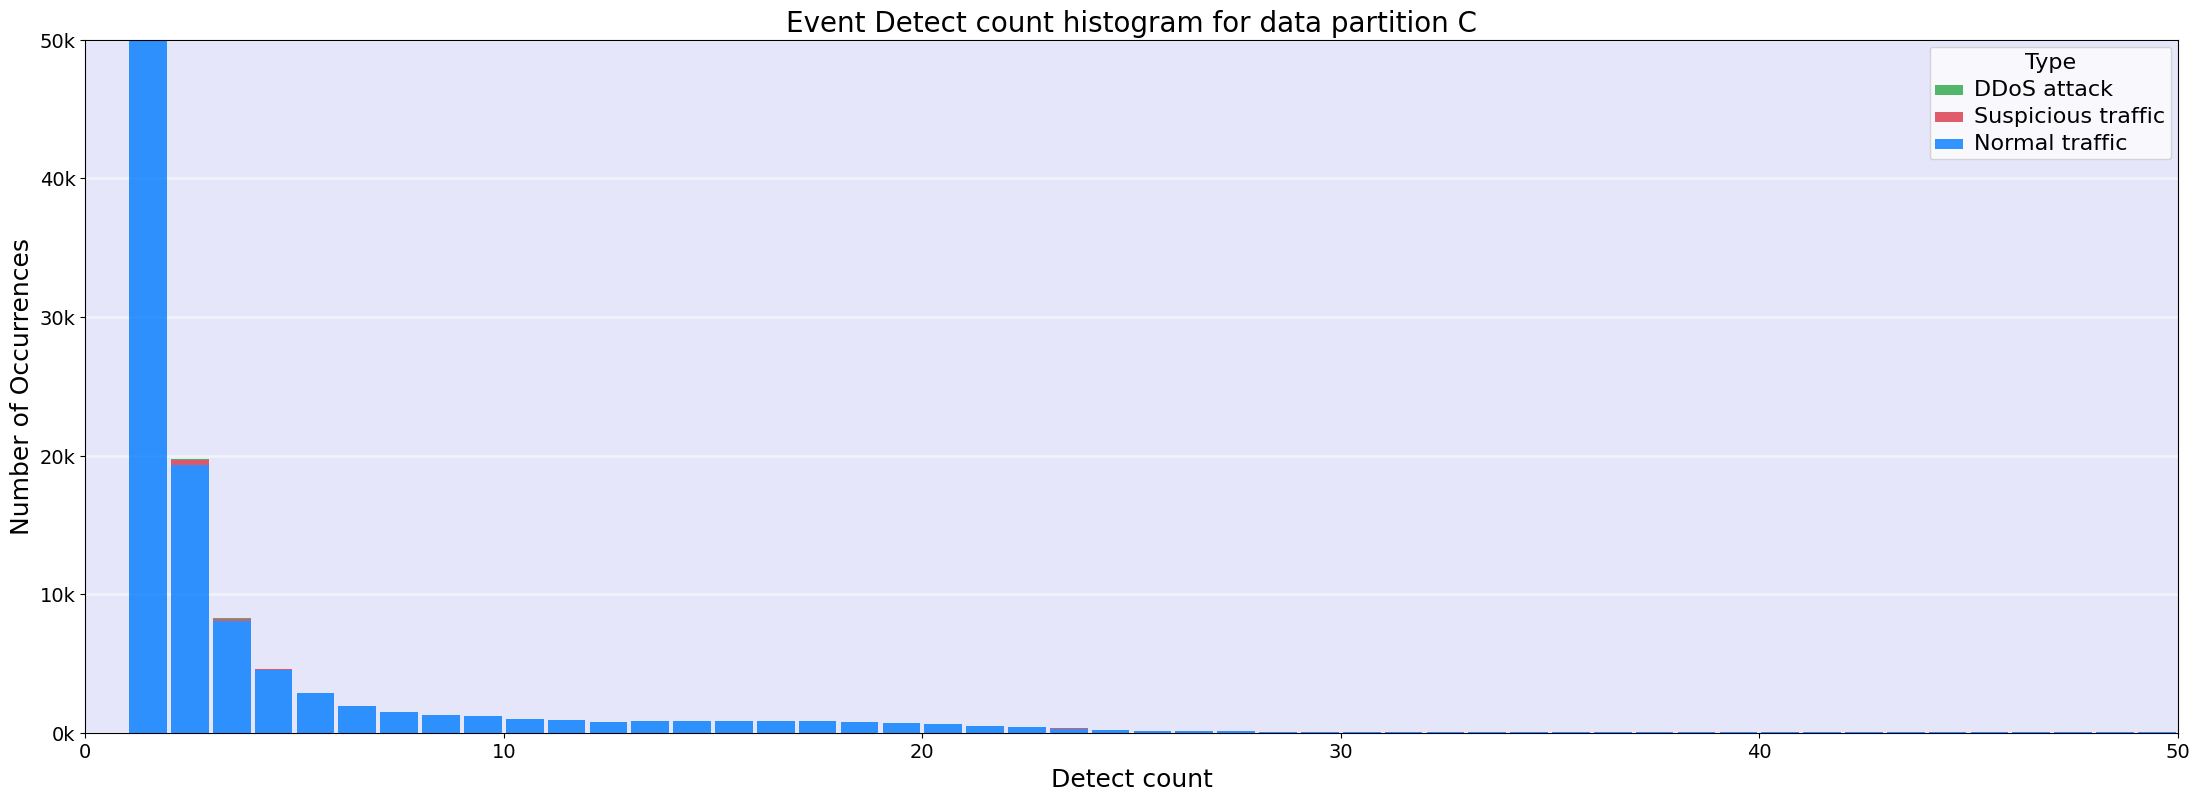

/tmp/ipykernel_729/3597966466.py:148: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = data.groupby(['bin', 'Type']).size().unstack(fill_value=0)


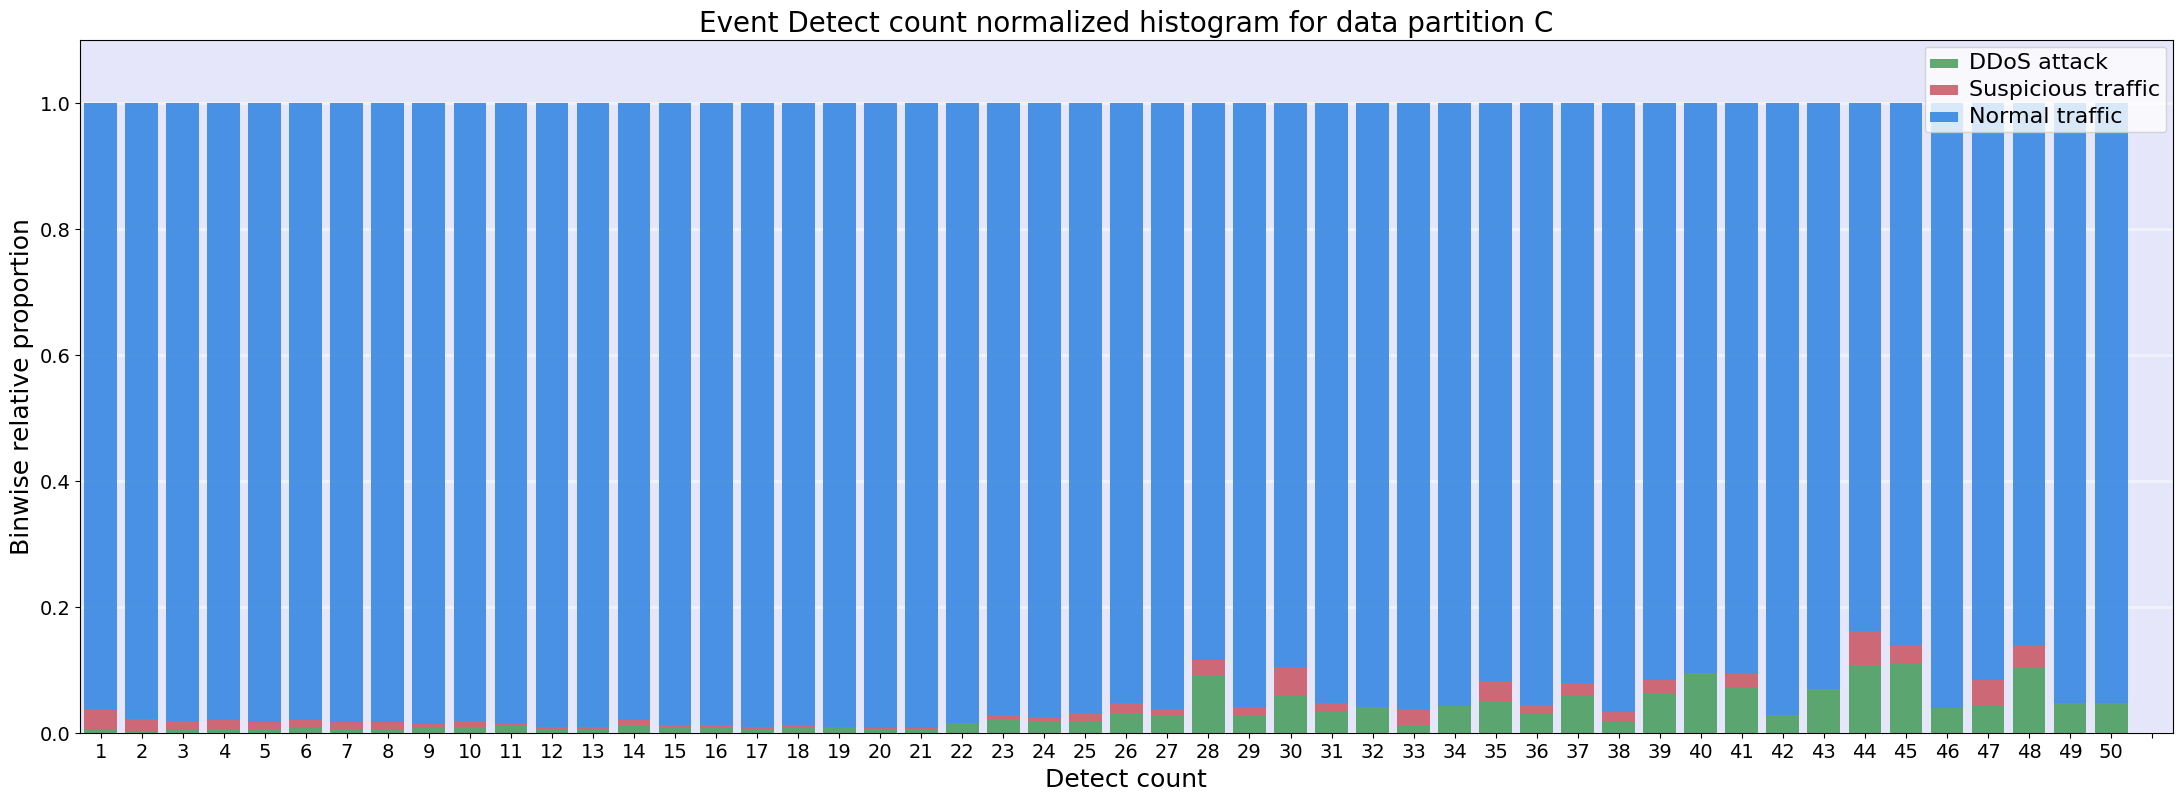

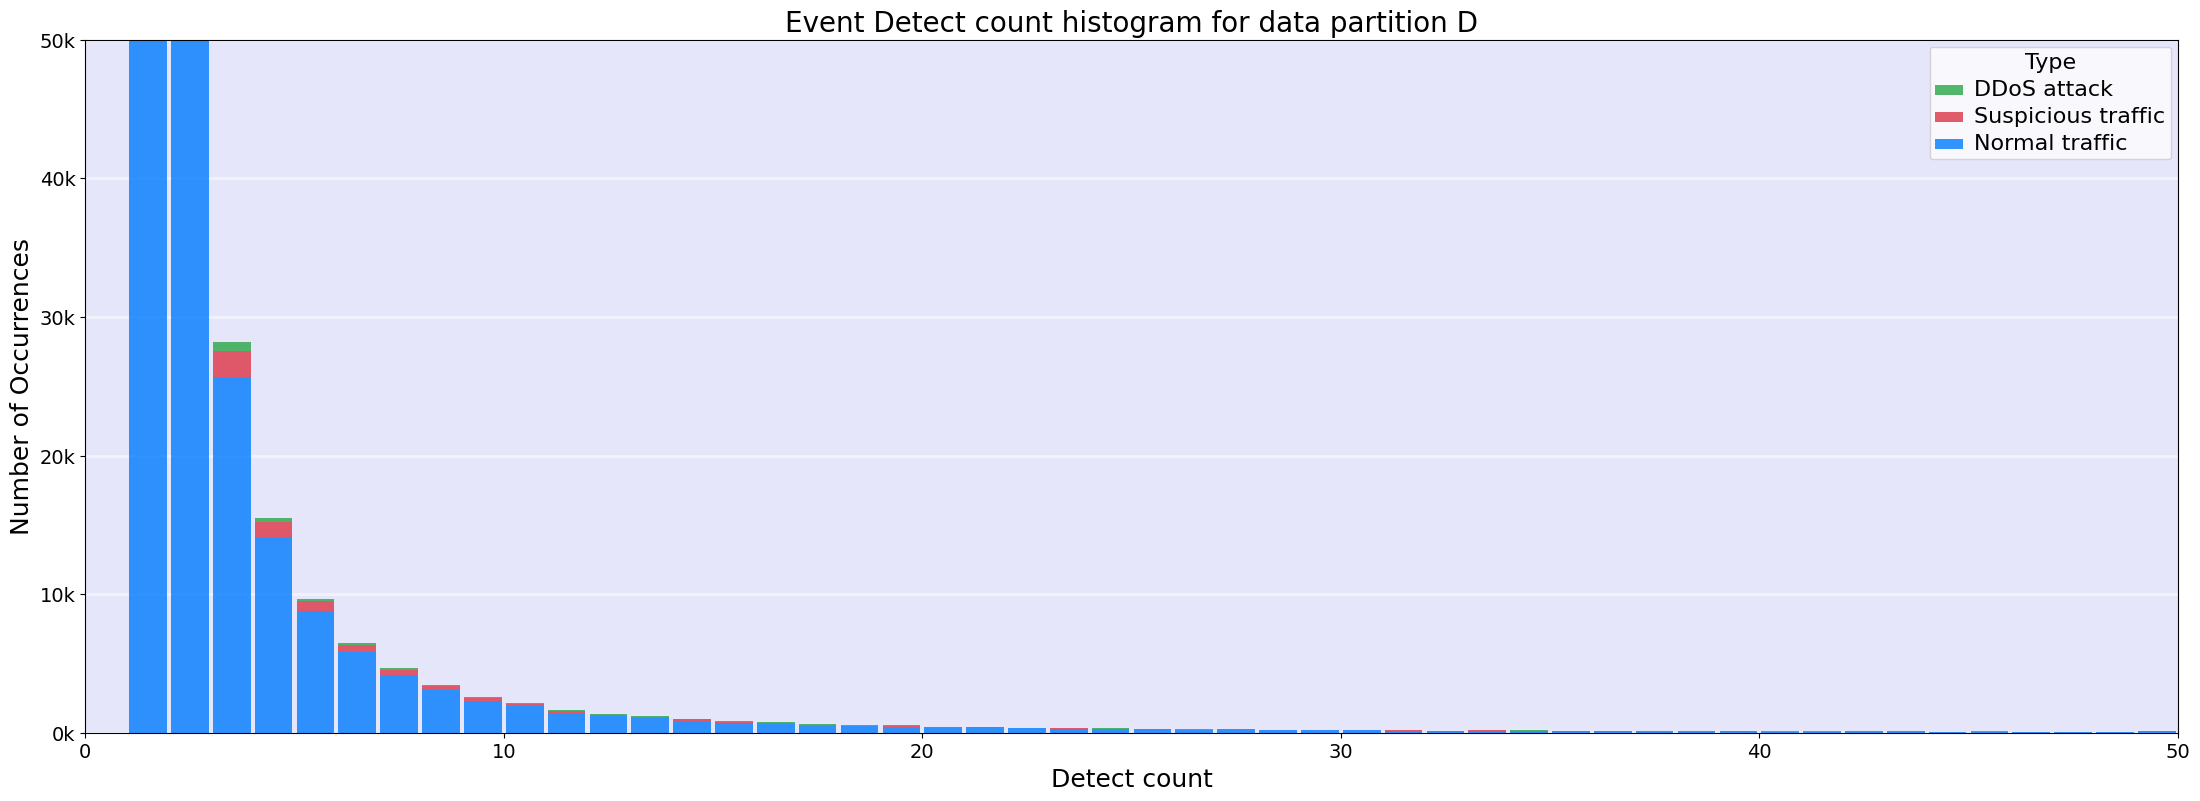

/tmp/ipykernel_729/3597966466.py:148: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = data.groupby(['bin', 'Type']).size().unstack(fill_value=0)


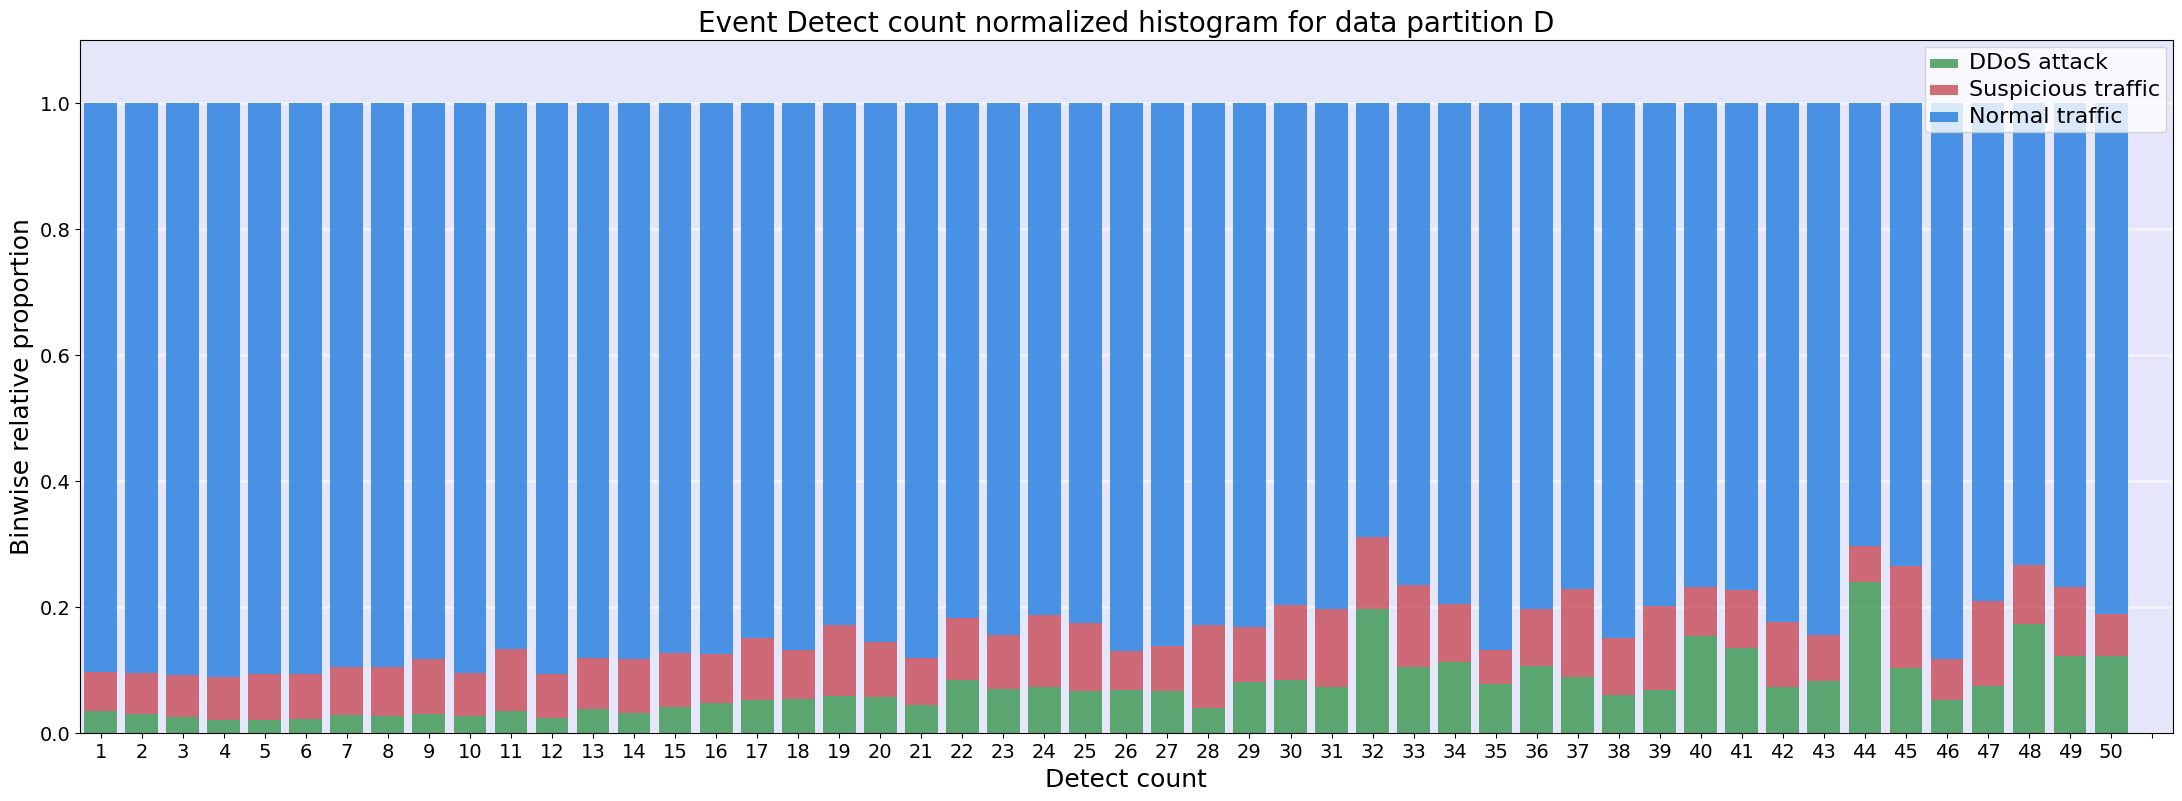

In [31]:
save_plots = False
fields = ['Duration', 'Detect count']
#fields = ['Avg packet len']

partition_a = DataPartition('A')
partition_b = DataPartition('B')
partition_c = DataPartition('C')
partition_d = DataPartition('D')

# partition_a.create_dist_pie_chart_for_events(save=save_plots)
# partition_b.create_dist_pie_chart_for_events(save=save_plots)
# partition_c.create_dist_pie_chart_for_events(save=save_plots)
# partition_d.create_dist_pie_chart_for_events(save=save_plots)

for field in fields:
    partition_a.create_histogram_for_events(field, save=save_plots)
    partition_a.create_normalized_histogram_for_events(field=field, save=save_plots)


    partition_b.create_histogram_for_events(field, save=save_plots)
    partition_b.create_normalized_histogram_for_events(field=field, save=save_plots)

    partition_c.create_histogram_for_events(field, save=save_plots)
    partition_c.create_normalized_histogram_for_events(field=field, save=save_plots)

    partition_d.create_histogram_for_events(field, save=save_plots)
    partition_d.create_normalized_histogram_for_events(field=field, save=save_plots)